In [99]:
import pyodbc    
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import Holt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import pmdarima as pm
from dateutil.relativedelta import relativedelta

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler

from prophet import Prophet
from prophet.diagnostics import cross_validation,performance_metrics


from scipy.stats import normaltest
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

# Getting Data

In [2]:
serverprop = ("Driver={SQL Server Native Client 11.0};"
            "Server=***;"
            "Database=***;"
            "UID=***;"
            "PWD=***;")
stp = pyodbc.connect(serverprop)

In [5]:
query1=" select TarikhForm as date,( sum(SalesQty)- sum(ReturnQty)) as sale from \
    (SELECT sdf.ccMoshtary as Moshtary,sdf.ccDarkhastFaktor as DarkhastFaktor,wk.TarikhForm as TarikhForm,wkala.CodeMother as Kcode,wks.Gheymat3 as Fee, sum(wks.Tedad3)as SalesQty, 0 as ReturnQty\
     FROM Warehouse.Kardex as wk left outer join Warehouse.KardexSatr as wks on wks.ccKardex=wk.ccKardex\
    left outer join Sales.darkhastfaktor as sdf on sdf.ccDarkhastFaktor=wk.ccRefrence\
    left outer join Warehouse.Kala as wkala on wkala.ccKalaCode=wks.ccKalaCode\
    where wk.CodeNoeForm=8 and wks.CodeNoeKala=1 and wk.CodeVazeiat=99\
    group by sdf.ccMoshtary,sdf.ccDarkhastFaktor,wk.TarikhForm,wkala.CodeMother,wks.Gheymat3\
    Union All\
    SELECT sdf.ccMoshtary,sdf.ccDarkhastFaktor,wk.TarikhForm,wkala.CodeMother,wks.Gheymat3,0 as SalesQty,sum(wks.Tedad3)as ReturnQty\
    FROM Warehouse.Kardex as wk left outer join Warehouse.KardexSatr as wks on wks.ccKardex=wk.ccKardex\
    left outer join Sales.darkhastfaktor as sdf on sdf.ccDarkhastFaktor=wk.ccRefrence\
    left outer join Warehouse.Kala as wkala on wkala.ccKalaCode=wks.ccKalaCode\
    where wk.CodeNoeForm in (10,57) and wks.CodeNoeKala=1 and wk.CodeVazeiat=99\
    group by sdf.ccMoshtary,sdf.ccDarkhastFaktor,wk.TarikhForm,wkala.CodeMother,wks.Gheymat3) as kol\
    where TarikhForm between '2019-03-20' and '2023-03-20' and Kcode=3029\
    group by TarikhForm\
    order by TarikhForm"

In [6]:
data = pd.read_sql( query1 , stp)

In [7]:
data.head()

,date,sale
0,2019-04-06 10:54:36.120,6.0
1,2019-04-06 11:52:27.140,6.0
2,2019-04-06 14:00:06.110,5.0
3,2019-04-06 14:15:40.650,24.0
4,2019-04-06 14:29:10.087,6.0


In [8]:
data.shape

(127455, 2)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127455 entries, 0 to 127454
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    127455 non-null  datetime64[ns]
 1   sale    127455 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 MB


In [10]:
data.describe()

,sale
count,127455.000000
mean,21.209376
std,74.175624
min,-2000.000000
25%,5.000000
50%,10.000000
75%,24.000000
max,4000.000000


In [11]:
data.set_index('date',inplace=True)

In [12]:
data.head()

,sale
date,
2019-04-06 10:54:36.120,6.0
2019-04-06 11:52:27.140,6.0
2019-04-06 14:00:06.110,5.0
2019-04-06 14:15:40.650,24.0
2019-04-06 14:29:10.087,6.0


# Feature Engineering and EDA

In [14]:
data['year']=data.index.year
data['month']=data.index.month
data['day']=data.index.day
data['day_of_week']=data.index.day_of_week
data['day_of_year']=data.index.day_of_year
data['hour']=data.index.hour
data.head()

,sale,year,month,day,day_of_week,day_of_year,hour
date,,,,,,,
2019-04-06 10:54:36.120,6.0,2019,4,6,5,96,10
2019-04-06 11:52:27.140,6.0,2019,4,6,5,96,11
2019-04-06 14:00:06.110,5.0,2019,4,6,5,96,14
2019-04-06 14:15:40.650,24.0,2019,4,6,5,96,14
2019-04-06 14:29:10.087,6.0,2019,4,6,5,96,14


In [15]:
data.reset_index(inplace=True)
data['year_month']=data['date'].dt.to_period('M')
data['year_month_day']=data['date'].dt.to_period('D')
data.head()

,date,sale,year,month,day,day_of_week,day_of_year,hour,year_month,year_month_day
0,2019-04-06 10:54:36.120,6.0,2019,4,6,5,96,10,2019-04,2019-04-06
1,2019-04-06 11:52:27.140,6.0,2019,4,6,5,96,11,2019-04,2019-04-06
2,2019-04-06 14:00:06.110,5.0,2019,4,6,5,96,14,2019-04,2019-04-06
3,2019-04-06 14:15:40.650,24.0,2019,4,6,5,96,14,2019-04,2019-04-06
4,2019-04-06 14:29:10.087,6.0,2019,4,6,5,96,14,2019-04,2019-04-06


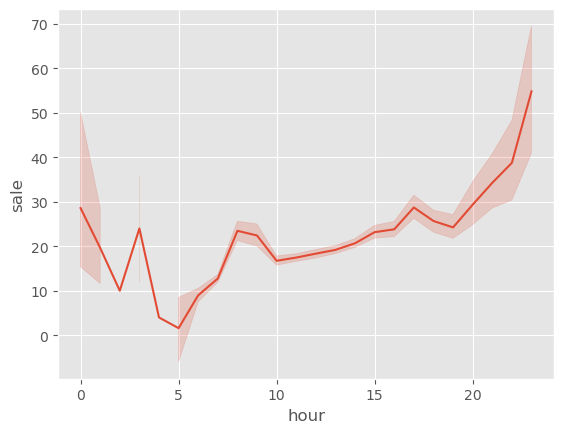

In [80]:
data.set_index('date',inplace=True)
sns.lineplot(data=data,x='hour',y='sale');

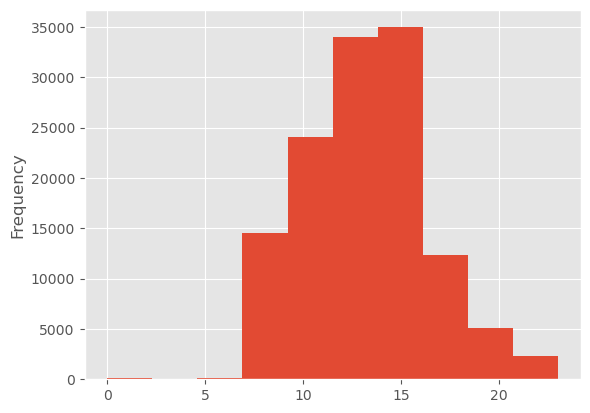

In [17]:
data.hour.plot(kind='hist');

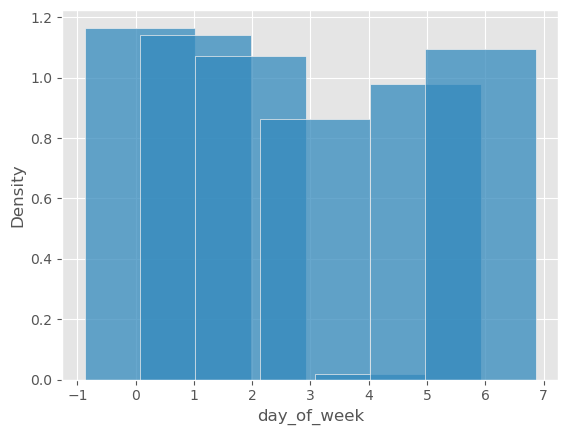

In [19]:
sns.histplot(data=data,x='day_of_week',stat='density',shrink=12);

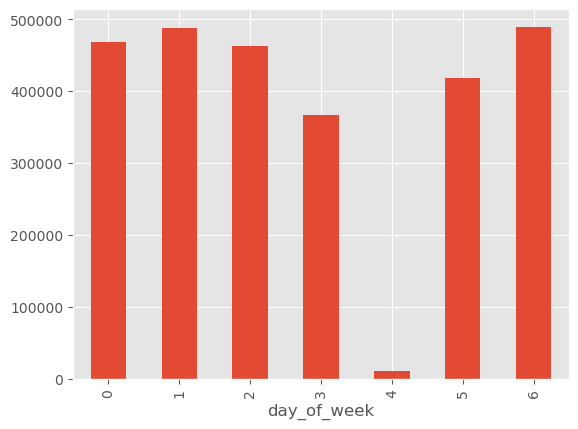

In [20]:
data.groupby('day_of_week').sum().sale.plot(kind='bar');

In [21]:
data.reset_index(inplace=True)

In [22]:
data

,date,sale,year,month,day,day_of_week,day_of_year,hour,year_month,year_month_day
0,2019-04-06 10:54:36.120,6.0,2019,4,6,5,96,10,2019-04,2019-04-06
1,2019-04-06 11:52:27.140,6.0,2019,4,6,5,96,11,2019-04,2019-04-06
2,2019-04-06 14:00:06.110,5.0,2019,4,6,5,96,14,2019-04,2019-04-06
3,2019-04-06 14:15:40.650,24.0,2019,4,6,5,96,14,2019-04,2019-04-06
4,2019-04-06 14:29:10.087,6.0,2019,4,6,5,96,14,2019-04,2019-04-06
...,...,...,...,...,...,...,...,...,...,...
127450,2023-03-15 23:46:29.933,12.0,2023,3,15,2,74,23,2023-03,2023-03-15
127451,2023-03-15 23:47:47.497,10.0,2023,3,15,2,74,23,2023-03,2023-03-15
127452,2023-03-15 23:55:41.780,5.0,2023,3,15,2,74,23,2023-03,2023-03-15
127453,2023-03-16 16:50:33.373,-100.0,2023,3,16,3,75,16,2023-03,2023-03-16


In [23]:
sales_hour=data.groupby(['year_month_day','hour'])['sale'].sum().reset_index()
sale_pivot=sales_hour.pivot(index='year_month_day',columns='hour',values='sale').fillna(0)
sale_pivot.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
year_month_day,,,,,,,,,,,,,,,,,,,,,
2019-04-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,74.0,130.0,137.0,82.0,86.0,7.0,26.0,67.0,75.0,0.0
2019-04-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,63.0,51.0,...,413.0,65.0,146.0,176.0,85.0,27.0,0.0,0.0,0.0,0.0
2019-04-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,250.0,3.0,...,370.0,91.0,227.0,159.0,163.0,20.0,0.0,0.0,0.0,0.0
2019-04-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,62.0,5.0,...,160.0,387.0,273.0,120.0,61.0,0.0,0.0,0.0,0.0,0.0
2019-04-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,113.0,41.0,...,237.0,391.0,374.0,168.0,40.0,-12.0,0.0,0.0,0.0,0.0


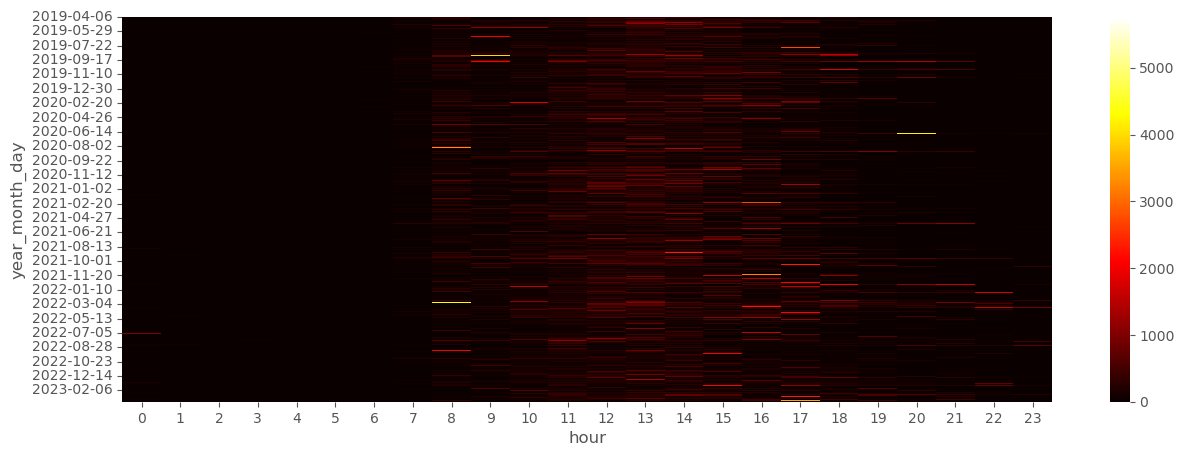

In [26]:
plt.figure(figsize=(15,5))
sns.heatmap(sale_pivot,cmap='hot',vmin=0);

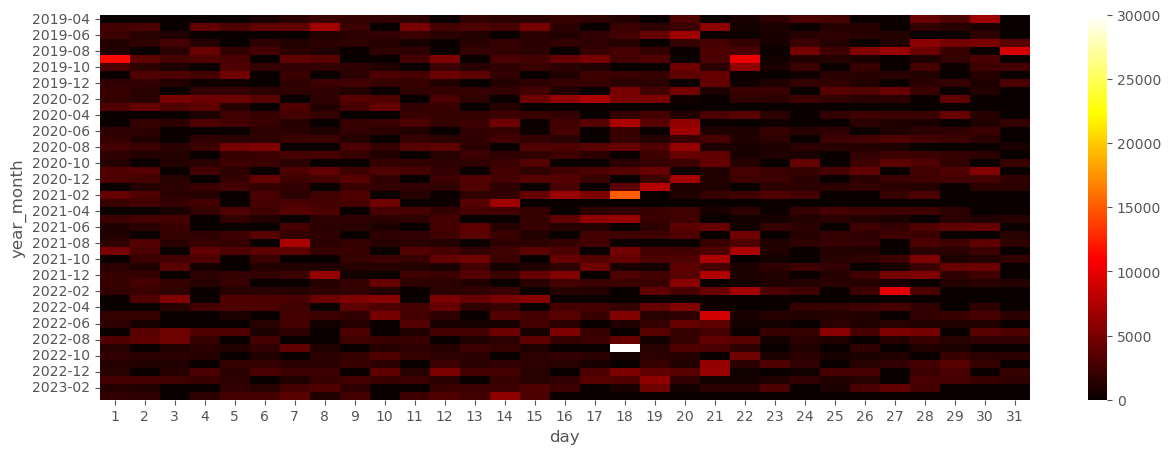

In [83]:
sales_day=data.groupby(['year_month','day'])['sale'].sum().reset_index()
sale_pivot_d=sales_day.pivot(index='year_month',columns='day',values='sale').fillna(0)
plt.figure(figsize=(15,5))
sns.heatmap(sale_pivot_d,cmap='hot',vmin=0,vmax=30000);

In [28]:
sales_monthly=data.groupby('year_month')['sale'].sum()
sales_monthly.index

PeriodIndex(['2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09',
             '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03',
             '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09',
             '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03',
             '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09',
             '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
             '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
             '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03'],
            dtype='period[M]', name='year_month')

In [29]:
sales_monthly.index=sales_monthly.index.to_timestamp()
sales_monthly.index

DatetimeIndex(['2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
               '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
               '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
               '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
               '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
               '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
               '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01'],
              dtype='datetime64[ns]', name='year_month', freq='MS')

In [30]:
len(sales_monthly.index.unique())

48

In [31]:
sales_daily=data.groupby('year_month_day')['sale'].sum()
sales_daily.head()

year_month_day
2019-04-06     696.0
2019-04-07    1624.0
2019-04-08    2144.0
2019-04-09    1895.0
2019-04-10    1815.0
Freq: D, Name: sale, dtype: float64

In [32]:
sales_daily.index=sales_daily.index.to_timestamp()
sales_daily.index

DatetimeIndex(['2019-04-06', '2019-04-07', '2019-04-08', '2019-04-09',
               '2019-04-10', '2019-04-11', '2019-04-13', '2019-04-14',
               '2019-04-15', '2019-04-16',
               ...
               '2023-03-07', '2023-03-08', '2023-03-09', '2023-03-11',
               '2023-03-12', '2023-03-13', '2023-03-14', '2023-03-15',
               '2023-03-16', '2023-03-19'],
              dtype='datetime64[ns]', name='year_month_day', length=1233, freq=None)

In [33]:
len(sales_daily.index.unique())

1233

In [34]:
our_date_range=sales_daily.index.max()-sales_daily.index.min()
our_date_range

Timedelta('1443 days 00:00:00')

In [35]:
new_index = pd.date_range(sales_daily.index.min(), sales_daily.index.max())
print(new_index)

DatetimeIndex(['2019-04-06', '2019-04-07', '2019-04-08', '2019-04-09',
               '2019-04-10', '2019-04-11', '2019-04-12', '2019-04-13',
               '2019-04-14', '2019-04-15',
               ...
               '2023-03-10', '2023-03-11', '2023-03-12', '2023-03-13',
               '2023-03-14', '2023-03-15', '2023-03-16', '2023-03-17',
               '2023-03-18', '2023-03-19'],
              dtype='datetime64[ns]', length=1444, freq='D')


In [36]:
sales_daily_new=sales_daily.reindex(new_index,fill_value=0)
sales_daily_new.index

DatetimeIndex(['2019-04-06', '2019-04-07', '2019-04-08', '2019-04-09',
               '2019-04-10', '2019-04-11', '2019-04-12', '2019-04-13',
               '2019-04-14', '2019-04-15',
               ...
               '2023-03-10', '2023-03-11', '2023-03-12', '2023-03-13',
               '2023-03-14', '2023-03-15', '2023-03-16', '2023-03-17',
               '2023-03-18', '2023-03-19'],
              dtype='datetime64[ns]', length=1444, freq='D')

In [37]:
sales_weekly = sales_daily_new.resample('W').sum()
sales_weekly.head()

2019-04-07     2320.0
2019-04-14    10907.0
2019-04-21     9573.0
2019-04-28    12413.0
2019-05-05    21976.0
Freq: W-SUN, Name: sale, dtype: float64

In [432]:
sales_monthly = sales_daily_new.resample('M').sum()
sales_monthly.head()

2019-04-30    44748.0
2019-05-31    69056.0
2019-06-30    40037.0
2019-07-31    55263.0
2019-08-31    69651.0
Freq: M, Name: sale, dtype: float64

In [39]:
sales_quarterly = sales_daily_new.resample('Q').sum()
sales_quarterly.head()

2019-06-30    153841.0
2019-09-30    206272.0
2019-12-31    151783.0
2020-03-31    164789.0
2020-06-30    149831.0
Freq: Q-DEC, Name: sale, dtype: float64

In [40]:
sales_annual = sales_daily_new.resample('Y').sum()
sales_annual

2019-12-31    511896.0
2020-12-31    671245.0
2021-12-31    692145.0
2022-12-31    687934.0
2023-12-31    140021.0
Freq: A-DEC, Name: sale, dtype: float64

In [45]:
window_size = 7
rolling_window = sales_monthly.rolling(window_size)
print('Rolling Mean')
print(rolling_window.mean().dropna().head())
print('\nRolling St. Dev')
print(rolling_window.std().dropna().head())
print('\nCumulative Sales')
print(sales_monthly.cumsum().dropna().head())

Rolling Mean
2019-10-31    58884.571429
2019-11-30    60396.285714
2019-12-31    56870.285714
2020-01-31    59170.428571
2020-02-29    62243.571429
Freq: M, Name: sale, dtype: float64

Rolling St. Dev
2019-10-31    14938.396376
2019-11-30    13758.206541
2019-12-31    14320.287121
2020-01-31    12319.130609
2020-02-29    13778.663226
Freq: M, Name: sale, dtype: float64

Cumulative Sales
2019-04-30     44748.0
2019-05-31    113804.0
2019-06-30    153841.0
2019-07-31    209104.0
2019-08-31    278755.0
Freq: M, Name: sale, dtype: float64


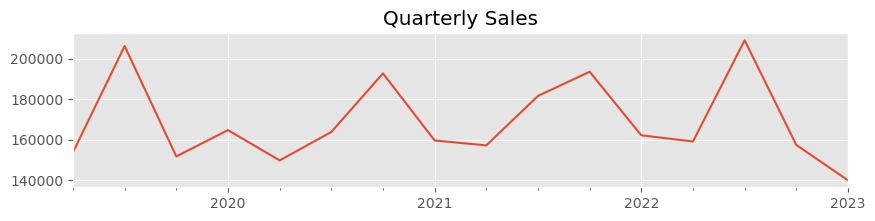

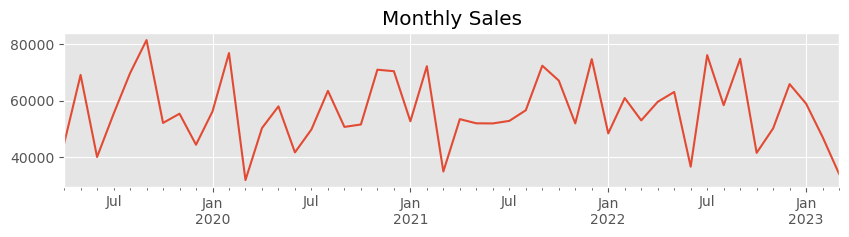

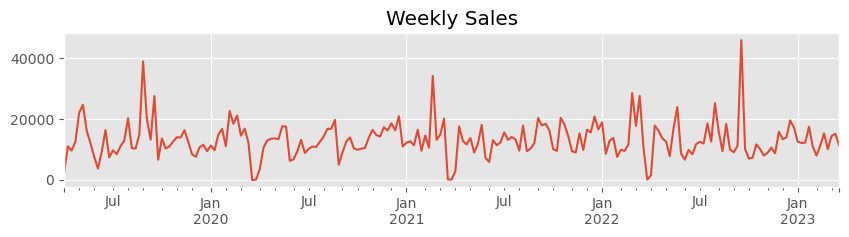

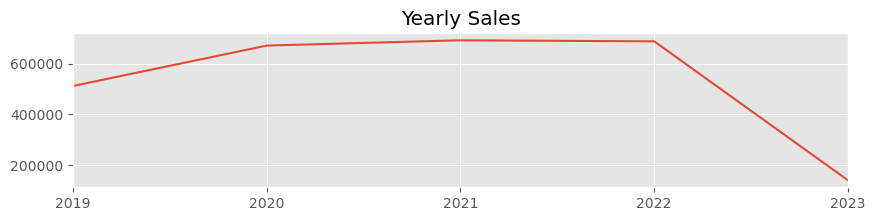

In [433]:
plotsize=(10,2)
sales_quarterly.plot(figsize=plotsize, title='Quarterly Sales')
plt.show()
sales_monthly.plot(figsize=plotsize, title='Monthly Sales')
plt.show()
sales_weekly.plot(figsize=plotsize, title='Weekly Sales')
plt.show()
sales_annual.plot(figsize=plotsize, title='Yearly Sales')
plt.show()

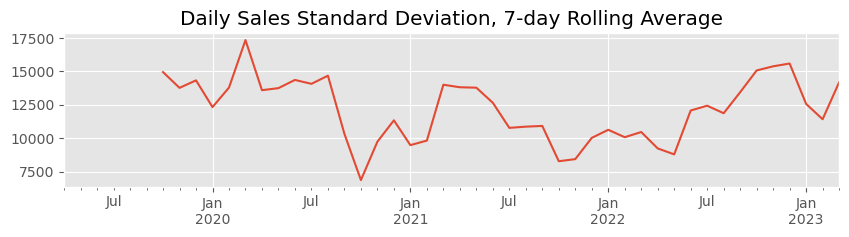

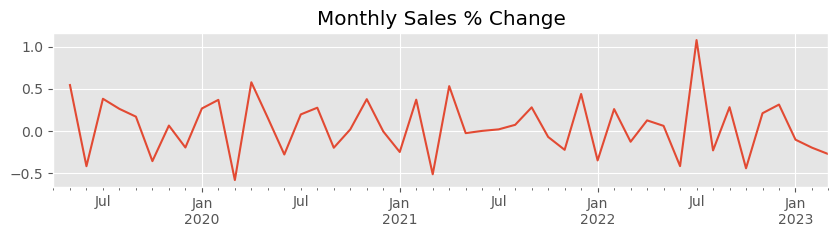

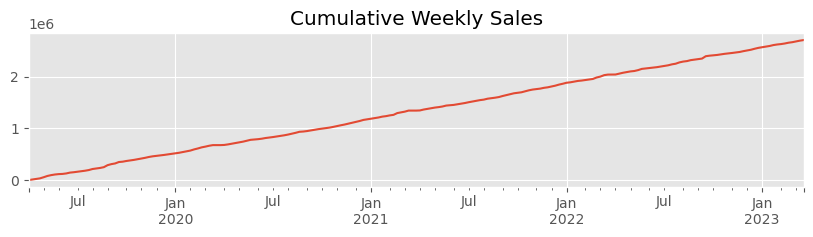

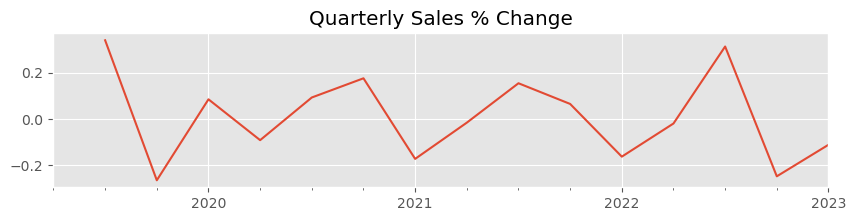

In [47]:
rolling_window.std().plot(figsize=plotsize, title='Daily Sales Standard Deviation, 7-day Rolling Average')
plt.show()

# Monthly Sales Percent Change
sales_monthly.pct_change().plot(figsize=plotsize, title='Monthly Sales % Change')
plt.show()

# Cumulative Weekly Sales
sales_weekly.cumsum().plot(figsize=plotsize, title='Cumulative Weekly Sales')
plt.show()

# Quarterly Sales Growth
sales_quarterly.pct_change().plot(figsize=plotsize, title='Quarterly Sales % Change')
plt.show()


# Decomposition

In [440]:
ss_decomposition = seasonal_decompose(x=sales_monthly, model='additive', period=6)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

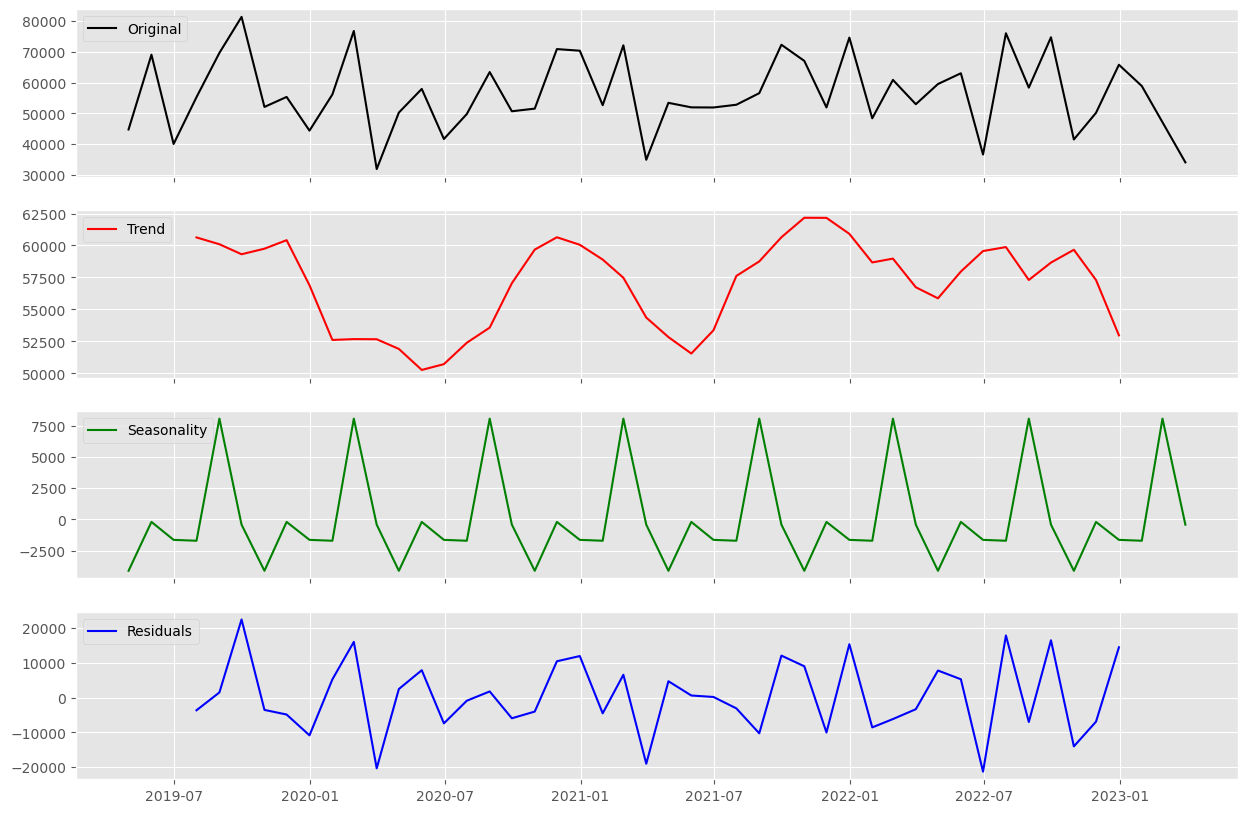

In [441]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(sales_monthly, label='Original',c='k')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend',c='r')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality',c='g')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals',c='b')
axes[3].legend(loc='upper left');

# Stationarity

In [62]:
chunks = np.split(sales_monthly, indices_or_sections=8)

In [63]:
np.mean(chunks,axis=1)

array([60018.83333333, 52762.        , 52280.83333333, 58740.5       ,
       56481.83333333, 59299.16666667, 61378.5       , 49578.5       ])

In [64]:
np.var(chunks,axis=1)

array([2.14149836e+08, 1.83611033e+08, 4.69927565e+07, 1.86493989e+08,
       5.24711398e+07, 8.51782611e+07, 1.70345655e+08, 1.10378854e+08])

In [65]:
# compare means and variances
print("{} | {:7} | {}".format("Chunk", "Mean", "Variance"))
print("-" * 26)
for i, chunk in enumerate(chunks, 1):
    print("{:5} | {:.6} | {:.6}".format(i, np.mean(chunk), np.var(chunk)))

Chunk | Mean    | Variance
--------------------------
    1 | 60018.8 | 2.1415e+08
    2 | 52762.0 | 1.83611e+08
    3 | 52280.8 | 4.69928e+07
    4 | 58740.5 | 1.86494e+08
    5 | 56481.8 | 5.24711e+07
    6 | 59299.2 | 8.51783e+07
    7 | 61378.5 | 1.70346e+08
    8 | 49578.5 | 1.10379e+08


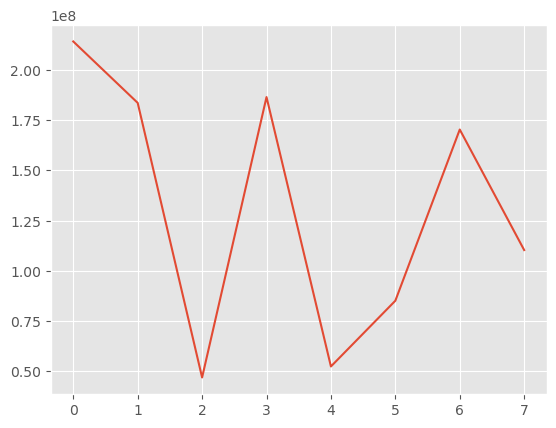

In [66]:
plt.plot(np.var(chunks,axis=1))

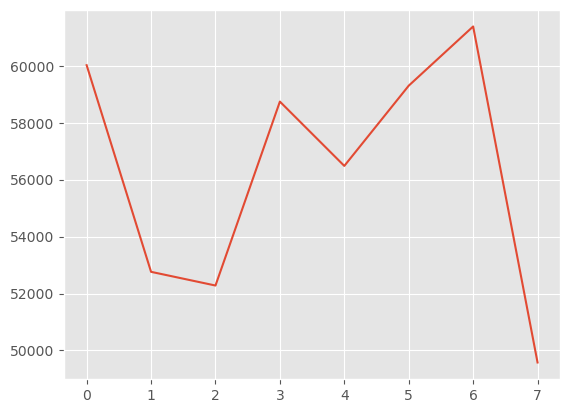

In [67]:
plt.plot(np.mean(chunks,axis=1))

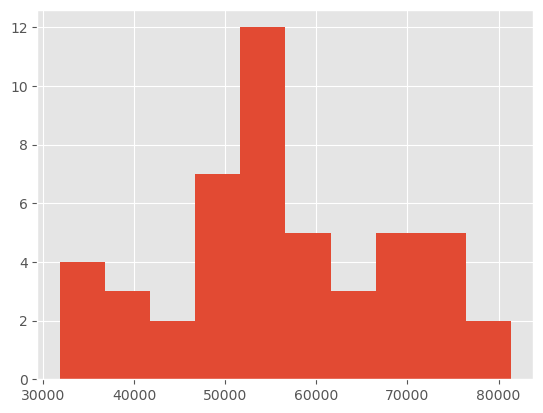

In [68]:
sales_monthly.hist();

In [69]:
#Test normal distribution
def normaltest_stat(data,alpha=0.05):
    k2, p_value = normaltest(data)
    if p_value < alpha:
        print("The null hypothesis can be rejected -  data is not normally distributed  ")
    else:
        print("The null hypothesis cannot be rejected -data comes from a normal distribution")

In [70]:
normaltest_stat(sales_monthly)

The null hypothesis cannot be rejected -data comes from a normal distribution


In [84]:
#Augmented Dickey-Fuller Test

def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic         -7.948379e+00
p-value                 3.174423e-12
Lags Used               0.000000e+00
Observations Used       4.700000e+01
Critical Value (1%)    -3.577848e+00
Critical Value (5%)    -2.925338e+00
Critical Value (10%)   -2.600774e+00
dtype: float64


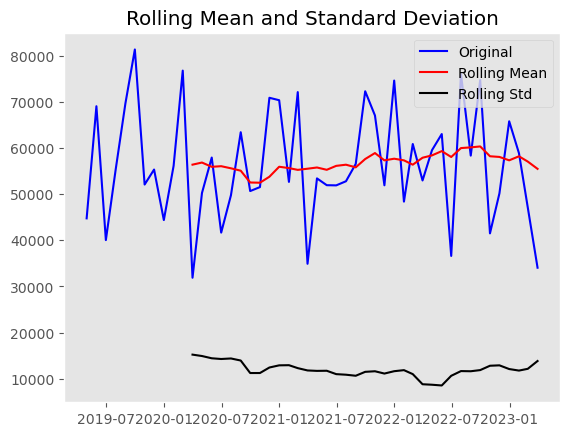

In [85]:
dftest(sales_monthly)

In [73]:
# the series is stationary.

In [74]:
def run_sequence_plot(x, y, title, xlabel="time", ylabel="series"):
    plt.plot(x, y, 'k-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3)
    plt.style.use('ggplot');

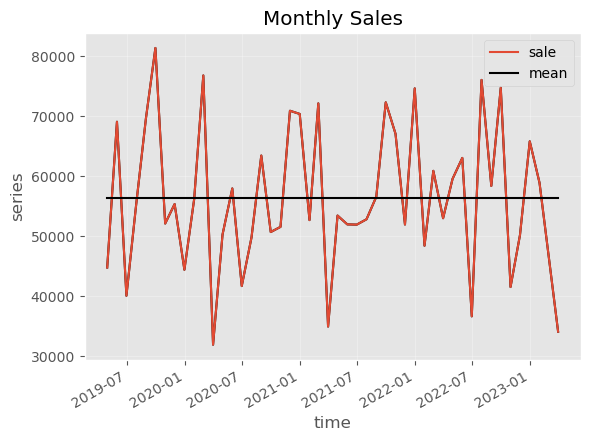

In [89]:
run_sequence_plot(x=sales_monthly.index,y=sales_monthly,title='Monthly Sales')
sales_monthly.plot()
sale_avg = np.full(shape=len(sales_monthly),
                  fill_value=np.mean(sales_monthly), dtype='float')
plt.plot(sales_monthly.index,sale_avg,label='mean',c='k')
plt.legend();

Monthly data Autocorrelation Plots


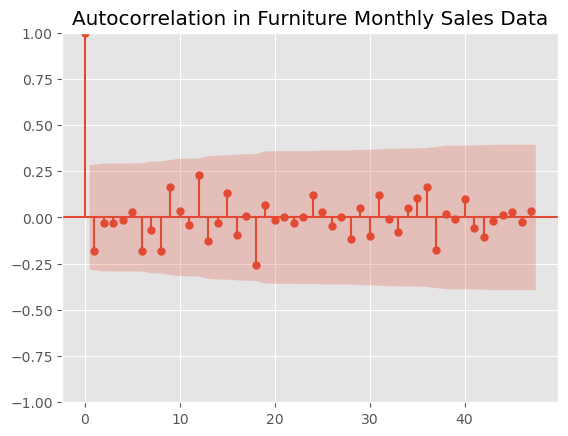

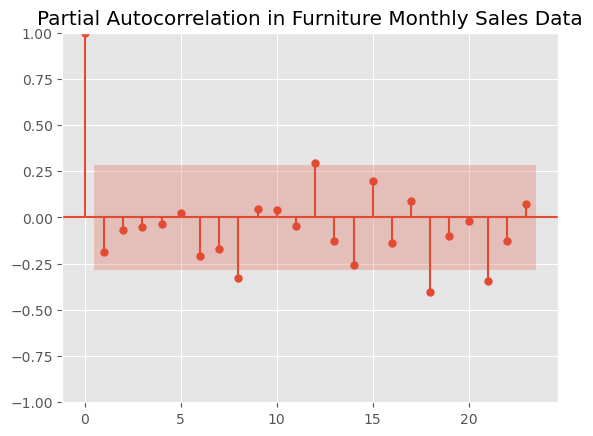

In [48]:
print('Monthly data Autocorrelation Plots')
# Autocorrelation and Partial Autocorrelation Functions for monthly Data
acf_plot = plot_acf(sales_monthly, lags=47, title='Autocorrelation in Furniture Monthly Sales Data')
pacf_plot = plot_pacf(sales_monthly, lags=23, title='Partial Autocorrelation in Furniture Monthly Sales Data')


Monthly Data Seasonal Plot


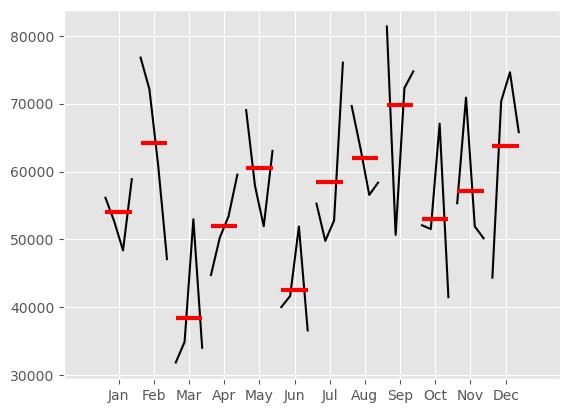

In [49]:
print('\nMonthly Data Seasonal Plot')
m_plot = month_plot(sales_monthly)


Quarterly Data Seasonal Plot


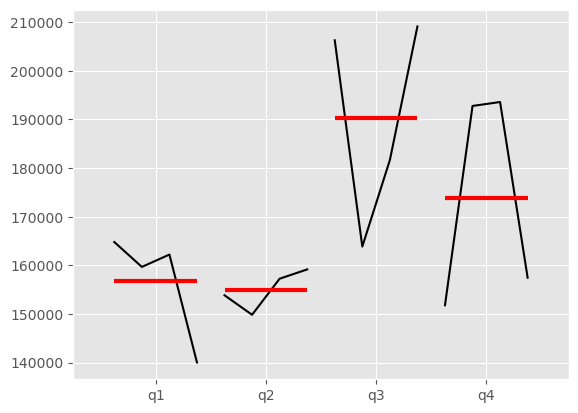

In [50]:
print('\nQuarterly Data Seasonal Plot')
q_plot = quarter_plot(sales_quarterly)

# Smoothing

# Train/Test Split

In [457]:
test=sales_monthly[-6:]
train=sales_monthly[:-6]

# Simple Average Smoothing

In [465]:
# find mean of series
sale_avg = np.mean(train)

# create array of mean value equal to length of time array
simple_avg_preds = np.full(shape=len(test), fill_value=sale_avg, dtype='float')

# mse
simple_mse = mean_squared_error(test, simple_avg_preds)

# results
print("Predictions: ", simple_avg_preds)
print("MSE: ", simple_mse)

Predictions:  [57280.23809524 57280.23809524 57280.23809524 57280.23809524
 57280.23809524 57280.23809524]
MSE:  169695623.270975


In [466]:
time=sales_monthly.index

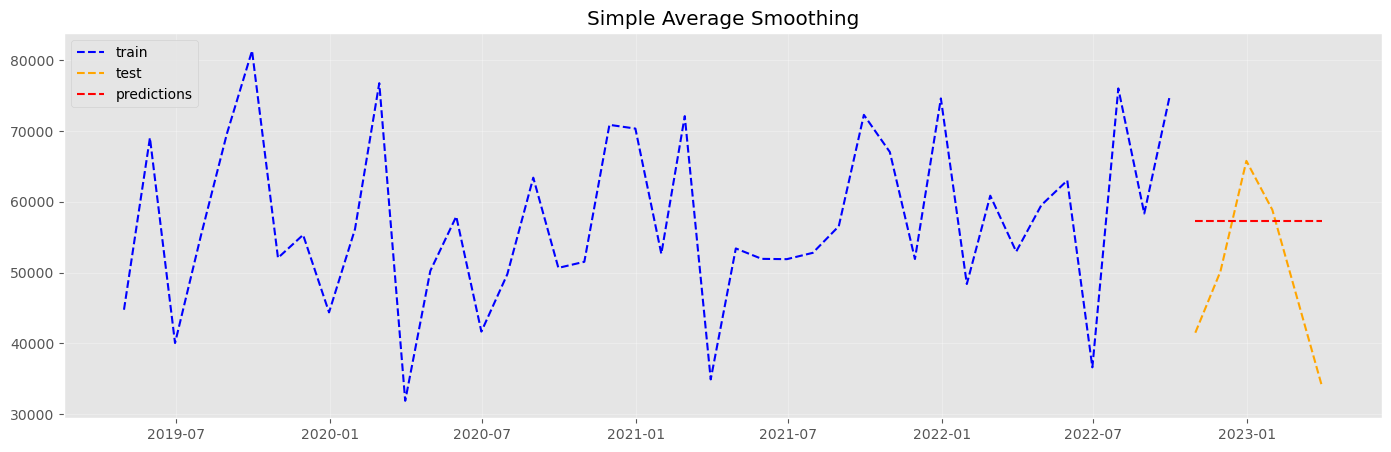

In [467]:
plt.plot(time[:-6], train, 'b--', label="train")
plt.plot(time[-6:], test, color='orange', linestyle="--", label="test")
plt.plot(time[-6:], simple_avg_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Simple Average Smoothing")
plt.grid(alpha=0.3);

# Single Exponential

In [468]:
single = SimpleExpSmoothing(train).fit(optimized=True)
single_preds = single.forecast(len(test))
single_mse = mean_squared_error(test, single_preds)
print("Predictions: ", single_preds)
print("MSE: ", single_mse)

Predictions:  2022-10-31    61779.789321
2022-11-30    61779.789321
2022-12-31    61779.789321
2023-01-31    61779.789321
2023-02-28    61779.789321
2023-03-31    61779.789321
Freq: M, dtype: float64
MSE:  259250314.67061844


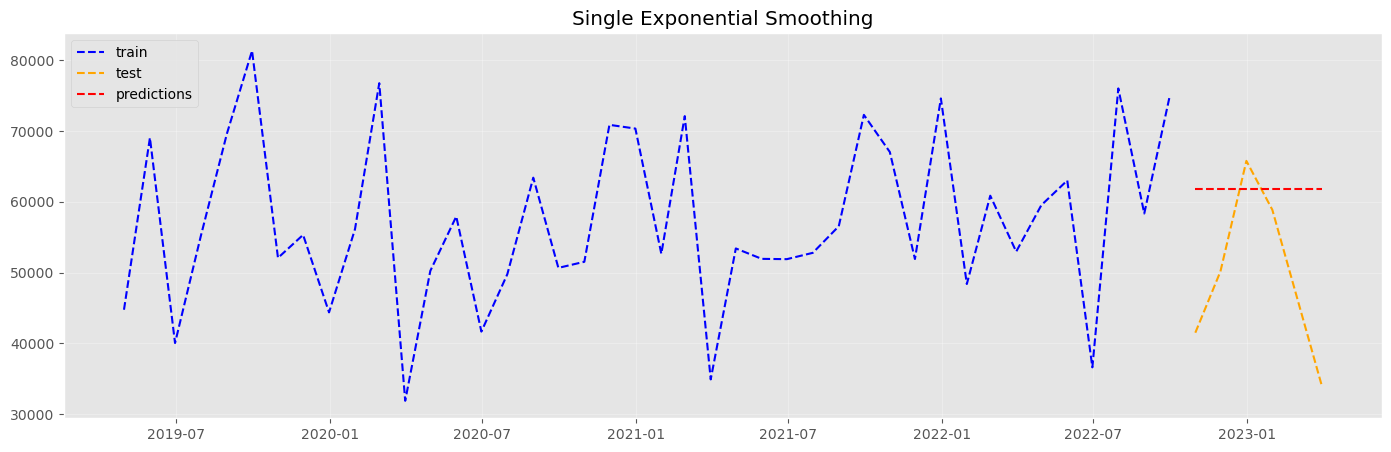

In [469]:
plt.plot(time[:-6], train, 'b--', label="train")
plt.plot(time[-6:], test, color='orange', linestyle="--", label="test")
plt.plot(time[-6:], single_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Single Exponential Smoothing")
plt.grid(alpha=0.3);

# Double Exponential

In [470]:
double = Holt(train).fit(optimized=True)
double_preds = double.forecast(len(test))
double_mse = mean_squared_error(test, double_preds)
print("Predictions: ", double_preds)
print("MSE: ", double_mse)

Predictions:  2022-10-31    72943.912278
2022-11-30    77719.778257
2022-12-31    82495.644236
2023-01-31    87271.510215
2023-02-28    92047.376194
2023-03-31    96823.242174
Freq: M, dtype: float64
MSE:  1465817890.0790803


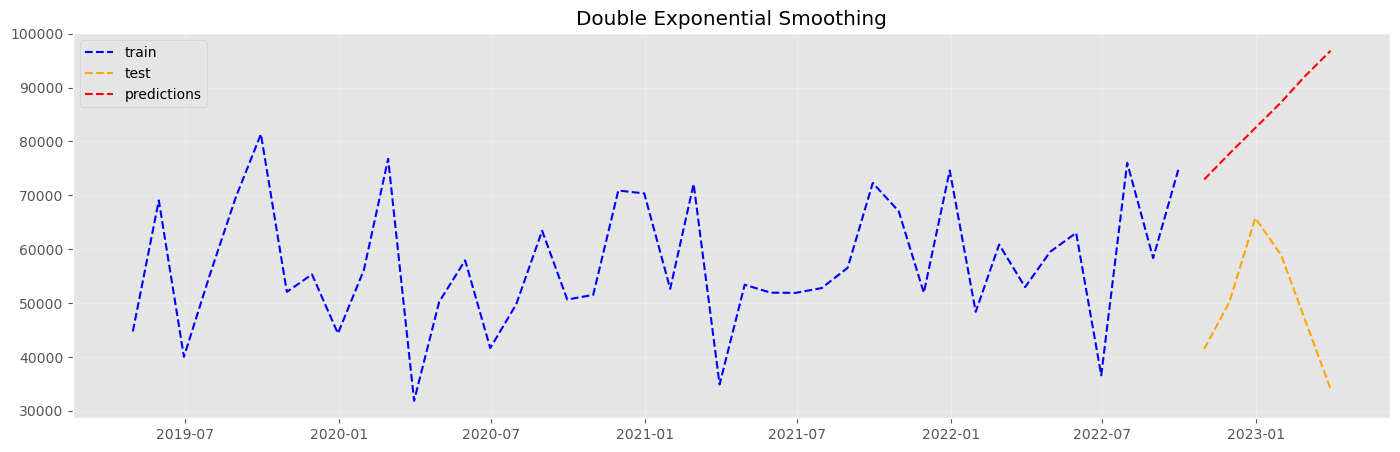

In [471]:
plt.plot(time[:-6], train, 'b--', label="train")
plt.plot(time[-6:], test, color='orange', linestyle="--", label="test")
plt.plot(time[-6:], double_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Double Exponential Smoothing")
plt.grid(alpha=0.3);

# Triple Exponential

In [472]:
triple = ExponentialSmoothing(train,
                              trend=None,
                              seasonal=None,seasonal_periods=None).fit(optimized=True)
triple_preds = triple.forecast(len(test))
triple_mse = mean_squared_error(test, triple_preds)
print("Predictions: ", triple_preds)
print("MSE: ", triple_mse)

Predictions:  2022-10-31    56688.911963
2022-11-30    56688.911963
2022-12-31    56688.911963
2023-01-31    56688.911963
2023-02-28    56688.911963
2023-03-31    56688.911963
Freq: M, dtype: float64
MSE:  160936811.8723322


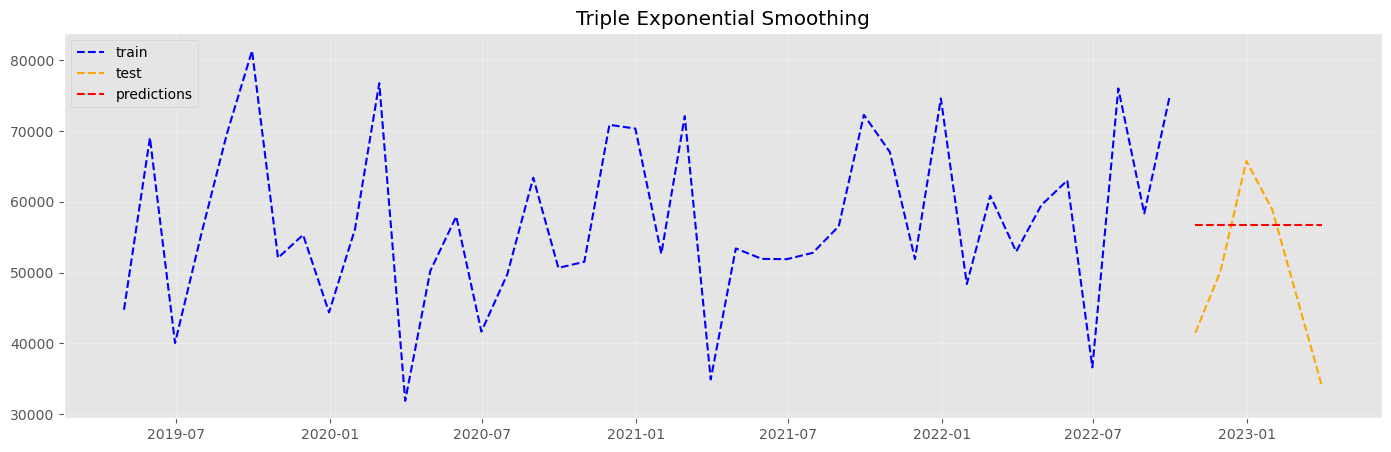

In [473]:
plt.plot(time[:-6], train, 'b--', label="train")
plt.plot(time[-6:], test, color='orange', linestyle="--", label="test")
plt.plot(time[-6:], triple_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Triple Exponential Smoothing")
plt.grid(alpha=0.3);

In [477]:
#Comparison
data_dict = {'MSE':[simple_mse, single_mse, double_mse, triple_mse]}
df_smoothing = pd.DataFrame(data_dict, index=['simple', 'single', 'double', 'triple']).sort_values('MSE')
print(df_smoothing)

                 MSE
triple  1.609368e+08
simple  1.696956e+08
single  2.592503e+08
double  1.465818e+09


# ARIMA - SARIMA

In [182]:
# define helper plot function for visualization
def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    plt.rcParams['figure.figsize'] = [17, 5]

    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

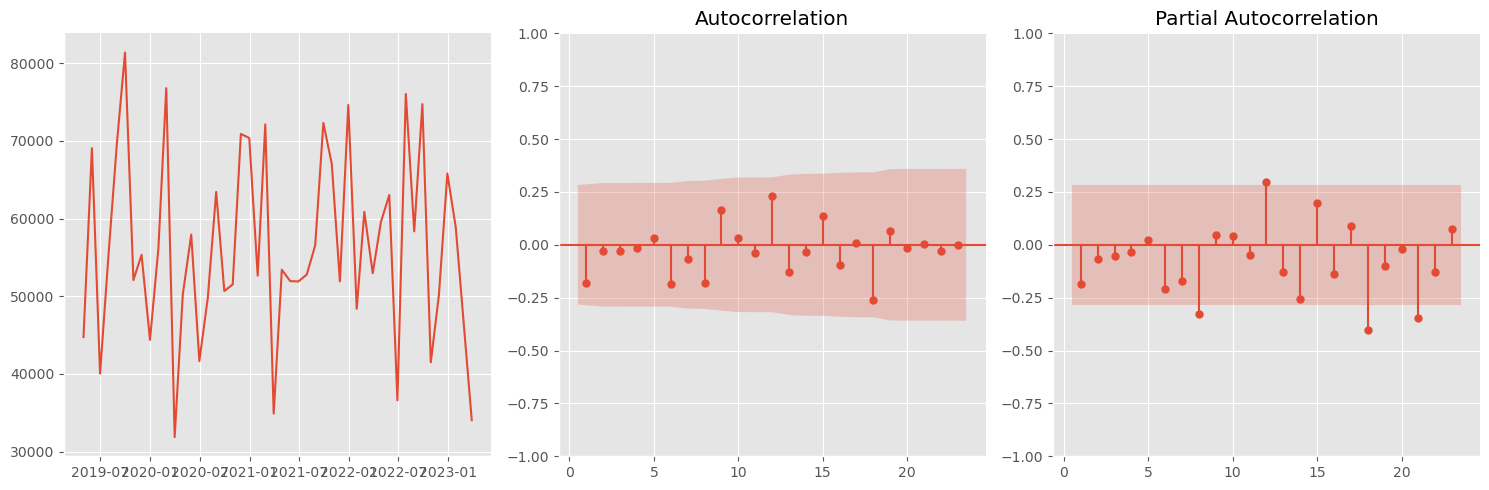

In [183]:
plots(sales_monthly, lags=23);

In [120]:
#AR
AR_model = ARIMA(train,order=(1,0,0),trend='n').fit()
AR_model_preds = AR_model.forecast(len(test))
AR_model_mse = mean_squared_error(test, AR_model_preds)
print("Predictions: ", AR_model_preds)
print("MSE: ", AR_model_mse)

Predictions:  2022-10-31    71037.390810
2022-11-30    67528.146946
2022-12-31    64192.259569
2023-01-31    61021.164876
2023-02-28    58006.722116
2023-03-31    55141.192691
Freq: M, Name: predicted_mean, dtype: float64
MSE:  290886245.4563395


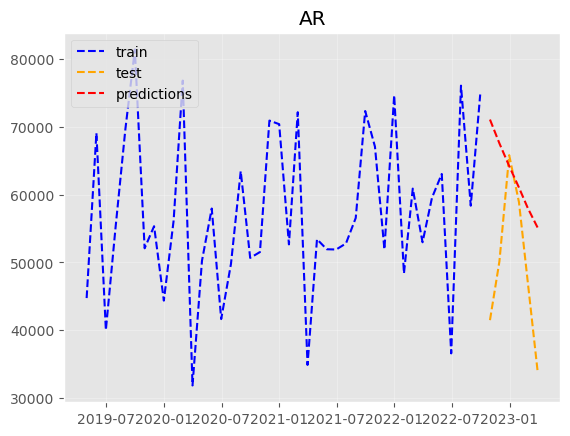

In [121]:
plt.plot(time[:-6], train, 'b--', label="train")
plt.plot(time[-6:], test, color='orange', linestyle="--", label="test")
plt.plot(time[-6:], AR_model_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("AR")
plt.grid(alpha=0.3);

In [143]:
#MA
MA_model = ARIMA(train,order=(0,0,8),trend='n').fit()
MA_model_preds = MA_model.forecast(len(test))
MA_model_mse = mean_squared_error(test, MA_model_preds)
print("Predictions: ", MA_model_preds)
print("MSE: ", MA_model_mse)

Predictions:  2022-10-31    61179.806039
2022-11-30    51372.255723
2022-12-31    45201.192638
2023-01-31    32989.574642
2023-02-28    25710.869865
2023-03-31    17231.009454
Freq: M, Name: predicted_mean, dtype: float64
MSE:  370521304.0438709


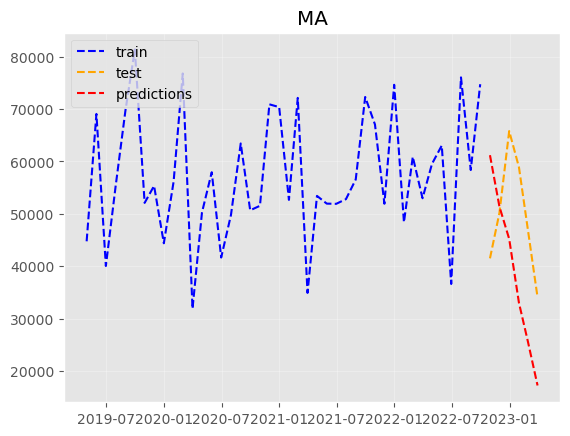

In [144]:
plt.plot(time[:-6], train, 'b--', label="train")
plt.plot(time[-6:], test, color='orange', linestyle="--", label="test")
plt.plot(time[-6:], MA_model_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("MA")
plt.grid(alpha=0.3);

In [458]:
#ARMA
ARMA_model = ARIMA(train,order=(4,0,3),trend='n').fit()
ARMA_model_preds = ARMA_model.forecast(len(test))
ARMA_model_mse = mean_squared_error(test, ARIMA_model_preds)
print("Predictions: ", ARMA_model_preds)
print("MSE: ", ARMA_model_mse)

Predictions:  2022-10-31    56024.894910
2022-11-30    55039.041882
2022-12-31    59683.267138
2023-01-31    55770.073276
2023-02-28    57810.563188
2023-03-31    57807.134349
Freq: M, Name: predicted_mean, dtype: float64
MSE:  160173858.003425


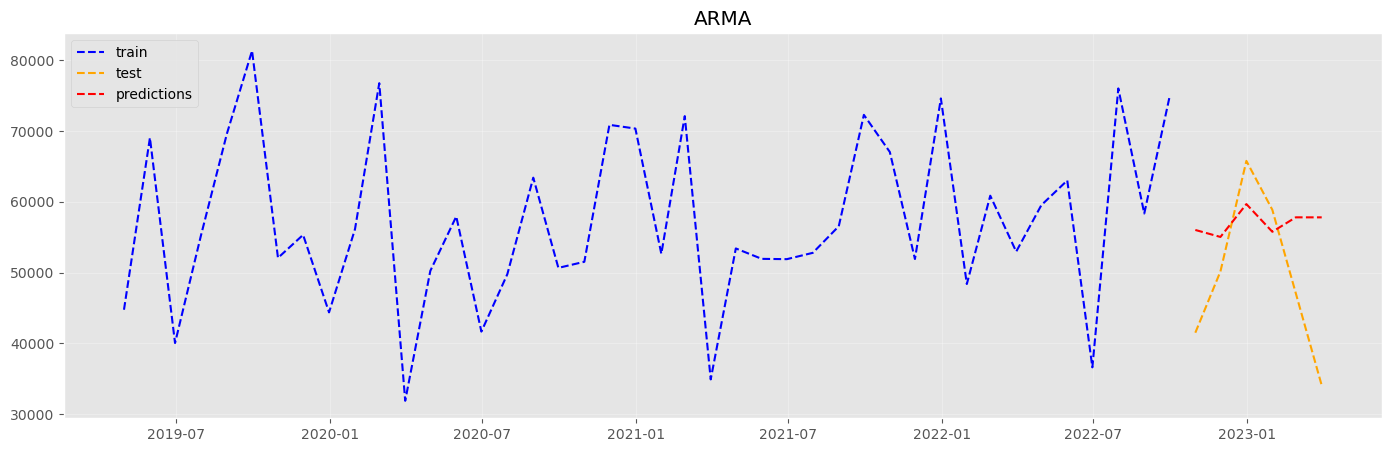

In [459]:
plt.plot(time[:-6], train, 'b--', label="train")
plt.plot(time[-6:], test, color='orange', linestyle="--", label="test")
plt.plot(time[-6:], ARMA_model_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("ARMA")
plt.grid(alpha=0.3);

In [460]:
#ARIMA
ARIMA_model = ARIMA(train,order=(4,1,7),trend='n').fit()
ARIMA_model_preds = ARIMA_model.forecast(len(test))
ARIMA_model_mse = mean_squared_error(test, ARIMA_model_preds)
print("Predictions: ", ARIMA_model_preds)
print("MSE: ", ARIMA_model_mse)

Predictions:  2022-10-31    54405.376093
2022-11-30    53984.055133
2022-12-31    67292.525971
2023-01-31    46458.746842
2023-02-28    59088.146979
2023-03-31    43037.879998
Freq: M, Name: predicted_mean, dtype: float64
MSE:  93716539.90413363


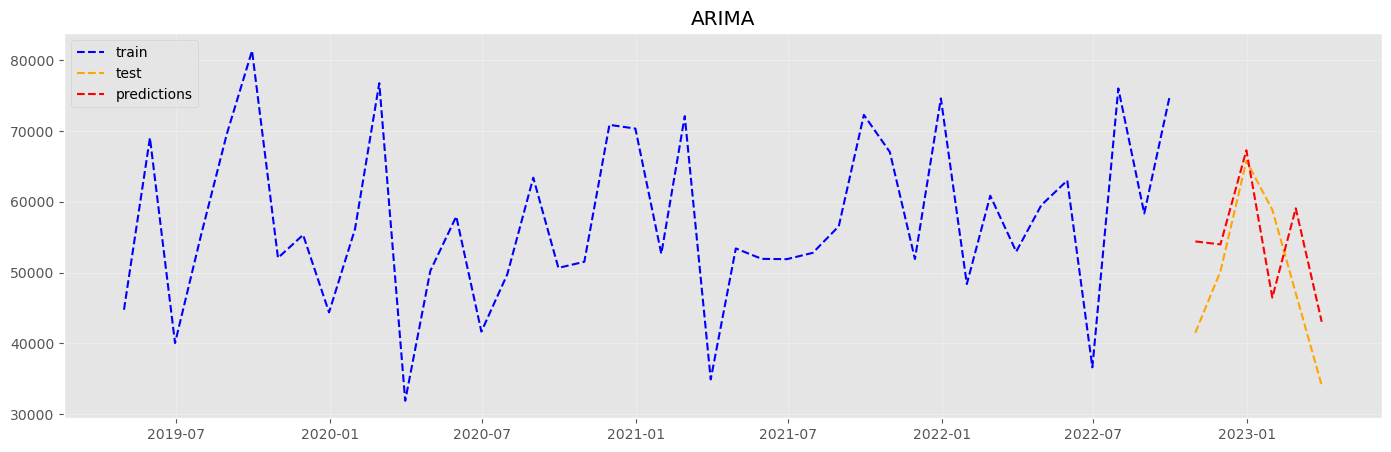

In [461]:
plt.plot(time[:-6], train, 'b--', label="train")
plt.plot(time[-6:], test, color='orange', linestyle="--", label="test")
plt.plot(time[-6:], ARIMA_model_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("ARIMA")
plt.grid(alpha=0.3);

In [289]:
#SARIMA
SARIMA_model = sm.tsa.statespace.SARIMAX(train, 
                                order=(4,1,7), 
                                seasonal_order=(0,0,1,9), 
                                trend=None).fit()
SARIMA_model_preds = SARIMA_model.forecast(len(test))
SARIMA_model_mse = mean_squared_error(test, SARIMA_model_preds)
print("Predictions: ", SARIMA_model_preds)
print("MSE: ", SARIMA_model_mse)

Predictions:  2022-10-31    62684.707209
2022-11-30    77142.975588
2022-12-31    78849.570656
2023-01-31    86387.504639
2023-02-28    82343.727784
2023-03-31    70881.774948
Freq: M, Name: predicted_mean, dtype: float64
MSE:  783896906.4183124


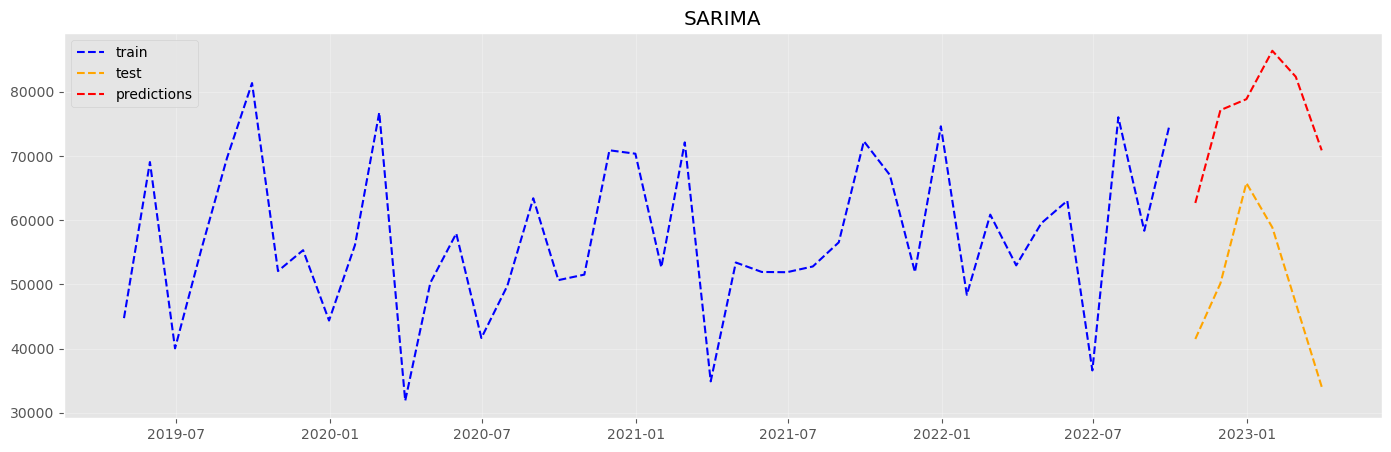

In [290]:
plt.plot(time[:-6], train, 'b--', label="train")
plt.plot(time[-6:], test, color='orange', linestyle="--", label="test")
plt.plot(time[-6:], SARIMA_model_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("SARIMA")
plt.grid(alpha=0.3);

In [291]:
#SARIMA
SARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                sale   No. Observations:                   42
Model:             SARIMAX(4, 1, 7)x(0, 0, [1], 9)   Log Likelihood                -452.282
Date:                             Tue, 02 May 2023   AIC                            930.564
Time:                                     12:21:54   BIC                            952.841
Sample:                                 04-30-2019   HQIC                           938.676
                                      - 09-30-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6981      0.223     -7.620      0.000      -2.135      -1.261
ar.L2         -0.2540      0.213     -1.192      0.233      -0.672       0.164
ar.L3          1.2580      0.305      4.128      0.000       0.661       1.855
ar.L4          0.7360      0.264      2.784      0.005       0.218       1.254
ma.L1          1.2251    373.688      0.003      0.997    -731.190     733.640
ma.L2         -0.7345   1244.456     -0.001      1.000   -2439.824    2438.355
ma.L3         -1.0721   2146.892     -0.000      1.000   -4208.902    4206.758
ma.L4          1.1374   2131.902      0.001      1.000   -4177.315    4179.589
ma.L5          0.6447   1214.304      0.001      1.000   -2379.348    2380.637
ma.L6         -1.2504    353.306     -0.004      0.997    -693.718     691.218
ma.L7         -0.9502      6.514     -0.146      0.884     -13.718      11.817
ma.S.L9        0.9924      6.990      0.142      0.887     -12.708      14.693
sigma2      4.709e+07      0.000   2.55e+11      0.000    4.71e+07    4.71e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.28
Prob(Q):                              0.98   Prob(JB):                         0.53
Heteroskedasticity (H):               1.13   Skew:                             0.15
Prob(H) (two-sided):                  0.82   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.13e+30. Standard errors may be unstable.
"""

In [292]:
# create and run statistical tests on model
norm_val, norm_p, skew, kurtosis = SARIMA_model.test_normality('jarquebera')[0]
lb_val, lb_p = SARIMA_model.test_serial_correlation(method='ljungbox',)[0]
het_val, het_p = SARIMA_model.test_heteroskedasticity('breakvar')[0]


# we want to look at largest lag for Ljung-Box, so take largest number in series
# there's intelligence in the method to determine how many lags back to calculate this stat
lb_val = lb_val[-1]
lb_p = lb_p[-1]
durbin_watson = sm.stats.stattools.durbin_watson(
    SARIMA_model.filter_results.standardized_forecasts_error[0, sar.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p),"Null hypothesis is normally distributed residuals ");
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p),":Null hypothesis is no serial correlation in residuals(independent of each other)");
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p),":Null hypothesis is no heteroskedasticity");
print('Durbin-Watson: d={:.2f}'.format(durbin_watson) ,":Tests autocorrelation of residuals")

Normality: val=1.275, p=0.529 Null hypothesis is normally distributed residuals 
Ljung-Box: val=3.166, p=0.923 :Null hypothesis is no serial correlation in residuals(independent of each other)
Heteroskedasticity: val=1.133, p=0.818 :Null hypothesis is no heteroskedasticity
Durbin-Watson: d=1.87 :Tests autocorrelation of residuals


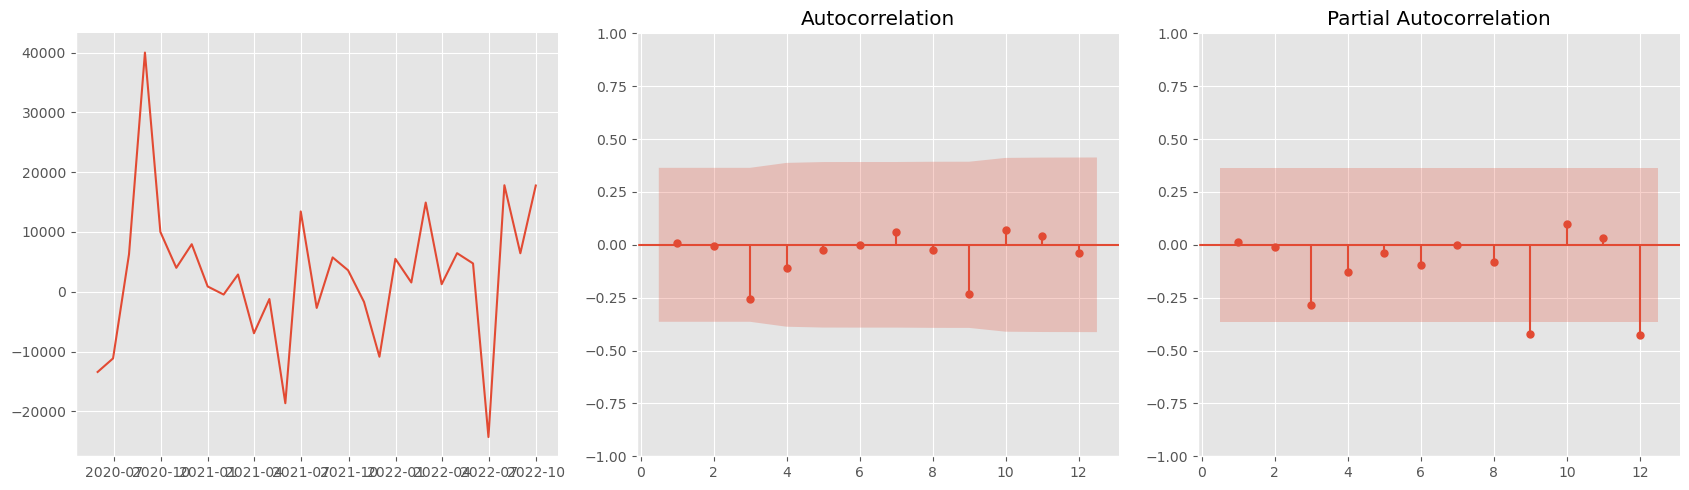

In [293]:
plots(SARIMA_model.resid[sar.loglikelihood_burn:], lags=12);

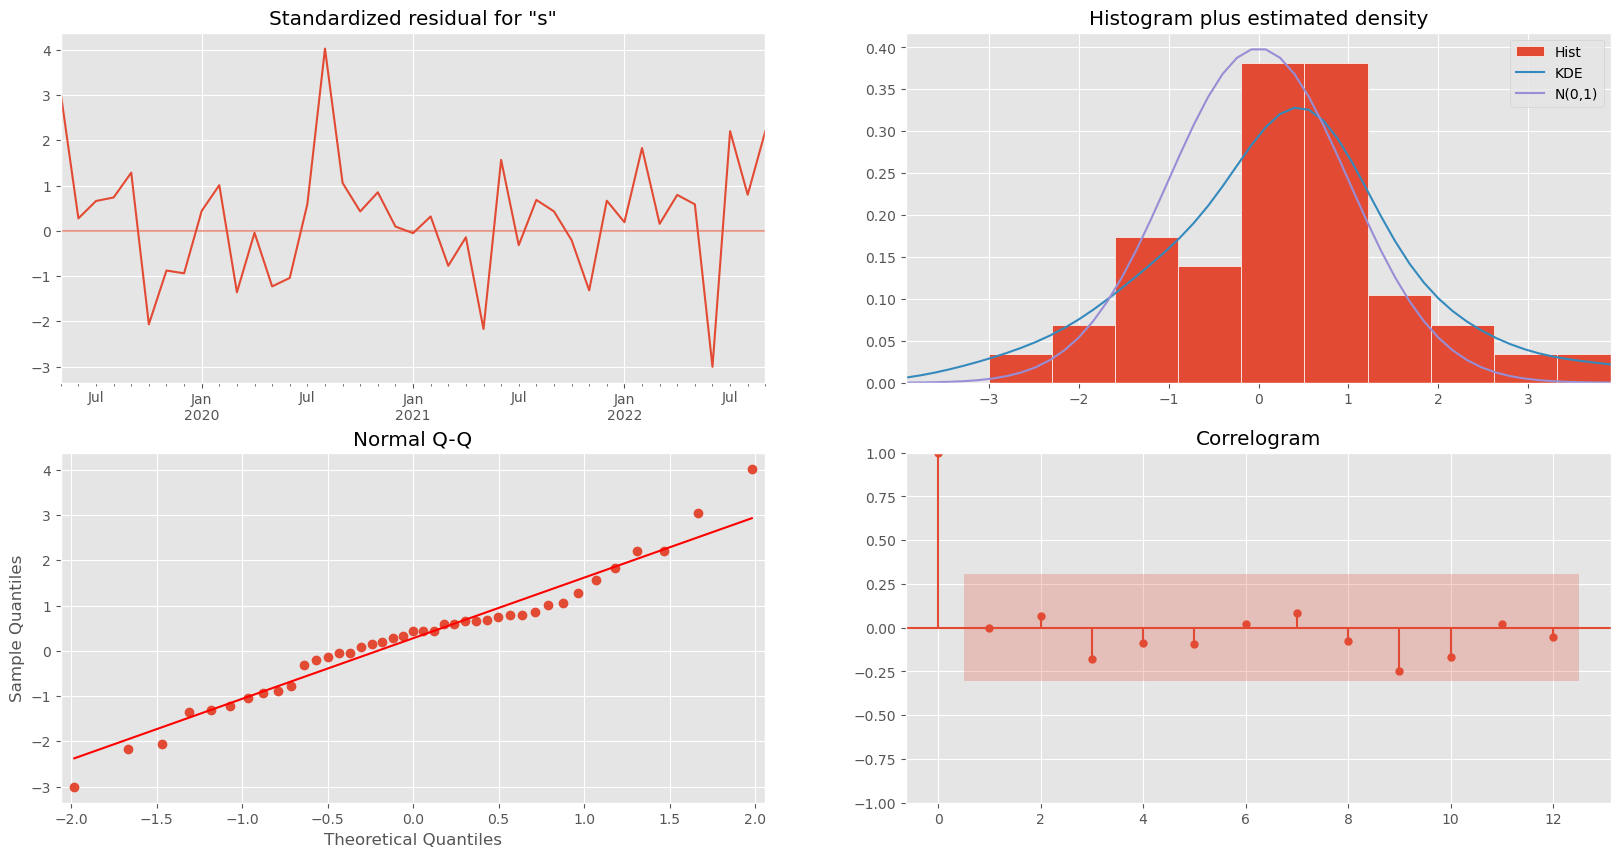

In [294]:
SARIMA_model.plot_diagnostics(lags=12,figsize = (20,10),);

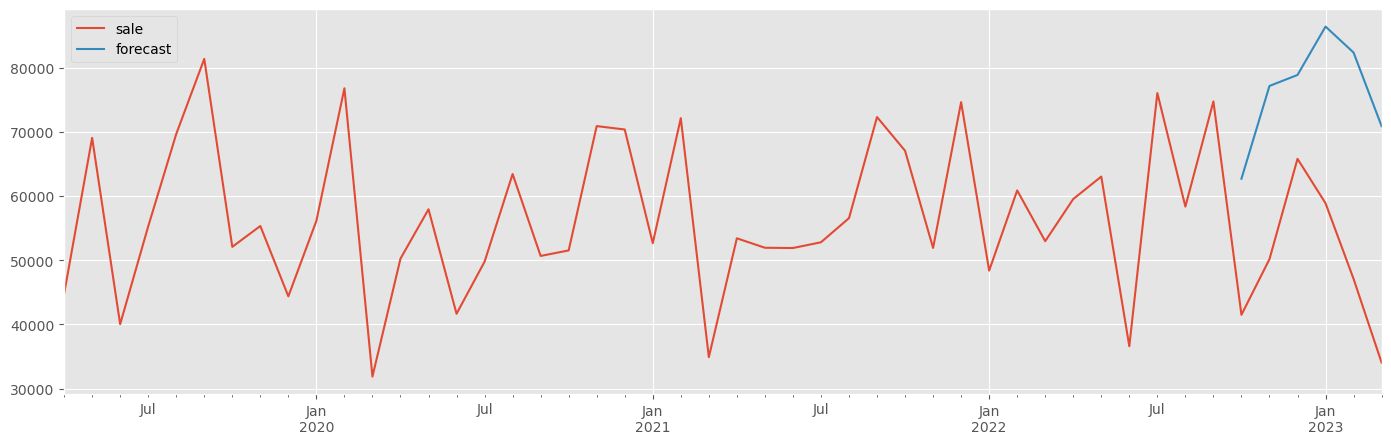

In [295]:
# plot predictions
pd.plotting.register_matplotlib_converters()
#use model.predict() start and end in relation to series
sales_monthly=pd.DataFrame(sales_monthly)
sales_monthly['forecast'] = SARIMA_model.predict(start = 42, end= 48)  
sales_monthly.plot();

In [463]:
#Comparison
data_dict = {'MSE':[AR_model_mse, MA_model_mse,ARMA_model_mse, ARIMA_model_mse,SARIMA_model_mse]}
df = pd.DataFrame(data_dict, index=['AR', 'MA','ARMA', 'ARIMA','SARIMA']).sort_values('MSE')
print(df)

                 MSE
ARIMA   9.371654e+07
ARMA    1.601739e+08
AR      2.908862e+08
MA      3.705213e+08
SARIMA  7.838969e+08


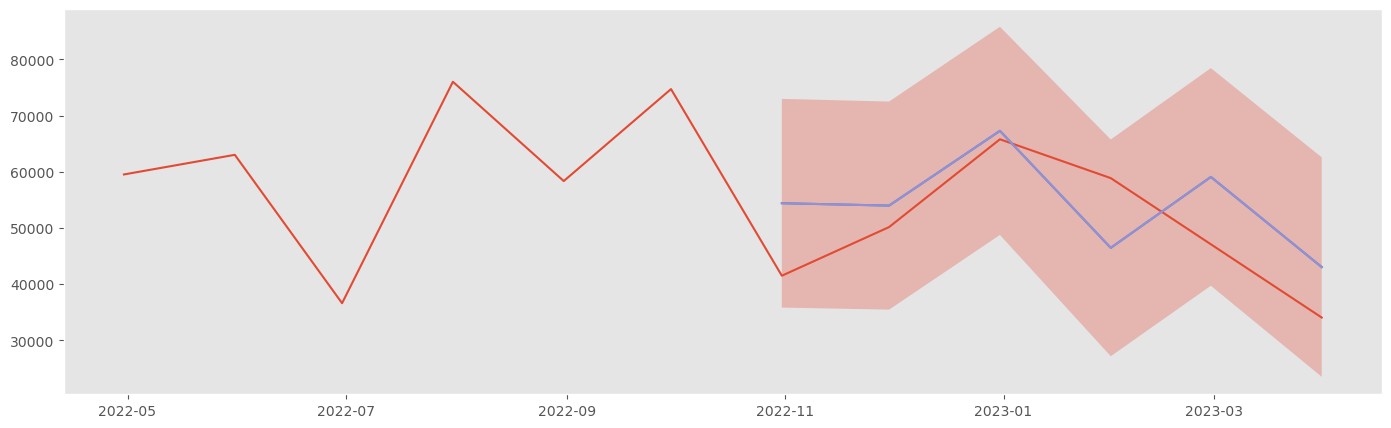

In [246]:
# can use get forecast to create a forecast object
future_fcst = SARIMA_model.get_forecast(6)
# That will have a method to pull in confidence interval 
confidence_int = future_fcst.conf_int(alpha = 0.01)
# Has an attribute to pull in predicted mean
fcst = future_fcst.predicted_mean
# Plot predictions and confidence intervals
plt.plot(sales_monthly[-12:])
plt.plot(fcst)
plt.fill_between(confidence_int.index,confidence_int['lower sale'],confidence_int['upper sale'],alpha = 0.3)
plt.grid()

In [218]:
#Autofit
#from pyramid.arima import auto_arima
stepwise_model = pm.auto_arima(sales_monthly.sale,
                               start_p=1, d=1, start_q=1,
                               max_p=12, max_d=3, max_q=12,
                               m=9,
                               start_P=0, D=0 , start_Q=0,
                               max_P=9, max_D=3, max_Q=12,
                               seasonal=True,trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[9] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[9] intercept   : AIC=1060.905, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[9] intercept   : AIC=1050.437, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[9] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[9]             : AIC=1058.923, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[9] intercept   : AIC=1052.667, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[9] intercept   : AIC=1049.627, Time=0.05 sec
 ARIMA(1,1,0)(3,0,0)[9] intercept   : AIC=1049.665, Time=0.12 sec
 ARIMA(1,1,0)(2,0,1)[9] intercept   : AIC=1050.711, Time=0.15 sec
 ARIMA(1,1,0)(1,0,1)[9] intercept   : AIC=1049.507, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[9] intercept   : AIC=1047.782, Time=0.03 sec
 ARIMA(1,1,0)(0,0,2)[9] intercept   : AIC=1049.384, Time=0.07 sec
 ARIMA(1,1,0)(1,0,2)[9] intercept   : AIC=1051.359, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[9] intercept   : AIC=1058.291, Time=0.03 sec
 ARIMA(2,1,0)(0,0,1)[9] intercept   : AIC=1

In [219]:
def future_preds_df(model,series,num_months):
    pred_first = series.index.max()+relativedelta(months=1)
    pred_last = series.index.max()+relativedelta(months=num_months)
    date_range_index = pd.date_range(pred_first,pred_last,freq = 'M')
    vals = model.predict(n_periods = num_months)
    return pd.DataFrame(vals,index = date_range_index)

In [220]:
preds = future_preds_df(stepwise_model,sales_monthly.sale,12)

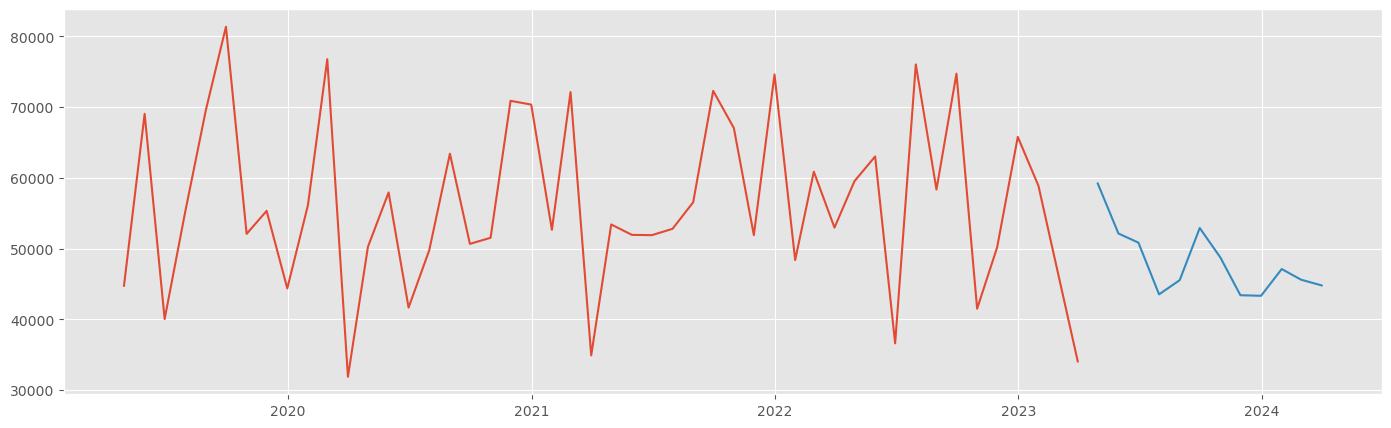

In [221]:
plt.plot(sales_monthly.sale)
plt.plot(preds)

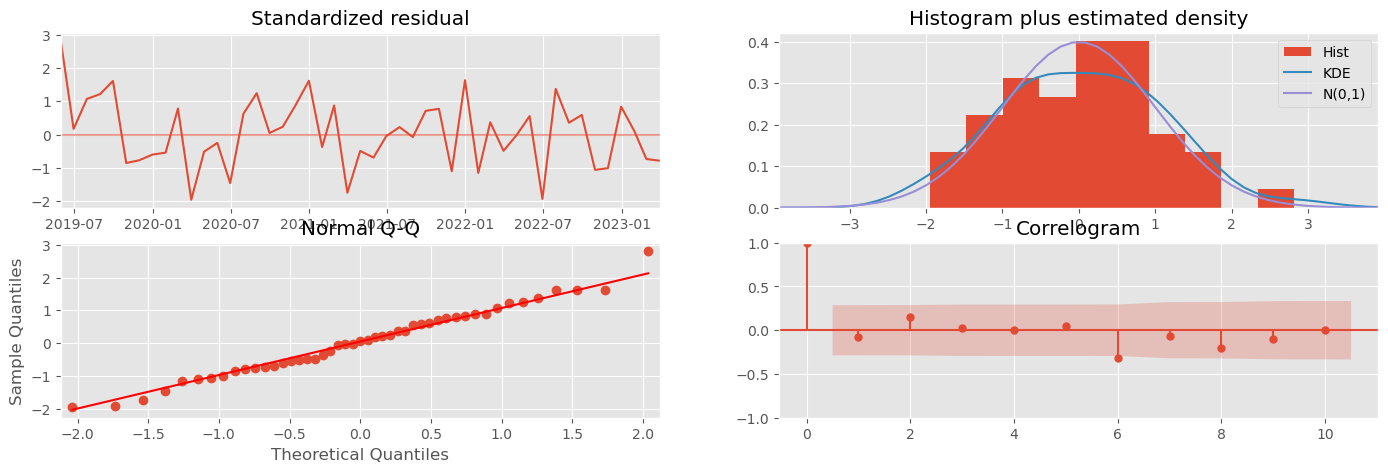

In [222]:
stepwise_model.plot_diagnostics();

In [238]:
def cross_validate(series,horizon,start,step_size,order = (1,0,0),seasonal_order = (0,0,0,0),trend=None):
    '''
    Function to determine in and out of sample testing of arima model    
    
    arguments
    ---------
    series (seris): time series input
    horizon (int): how far in advance forecast is needed
    start (int): starting location in series
    step_size (int): how often to recalculate forecast
    order (tuple): (p,d,q) order of the model
    seasonal_order (tuple): (P,D,Q,s) seasonal order of model
    
    Returns
    -------
    DataFrame: gives fcst and actuals with date of prediction
    '''
    fcst = []
    actual = []
    date = []
    for i in range(start,len(series)-horizon,step_size):
        model = sm.tsa.statespace.SARIMAX(series[:i+1], #only using data through to and including start 
                                order=order, 
                                seasonal_order=seasonal_order, 
                                trend=trend).fit()
        fcst.append(model.forecast(steps = horizon)[-1]) #forecasting horizon steps into the future
        actual.append(series[i+horizon]) # comparing that to actual value at that point
        date.append(series.index[i+horizon]) # saving date of that value
    return pd.DataFrame({'fcst':fcst,'actual':actual},index=date)

In [297]:
warnings.filterwarnings("ignore")
series = sales_monthly.sale
horizon = 1
start = 41
step_size = 1
order = (4,1,7)
seasonal_order = None

cv1 = cross_validate(series=series,horizon=horizon,start=start,step_size=step_size,
                    order = order,
                    seasonal_order = seasonal_order)

In [298]:
cv1

,fcst,actual
2022-10-31,54405.376093,41497.0
2022-11-30,59525.019458,50161.0
2022-12-31,67675.832732,65792.0
2023-01-31,39707.546999,58876.0
2023-02-28,59111.399518,47095.0
2023-03-31,51586.706775,34050.0


<AxesSubplot:title={'center':'forecast using prior data'}>

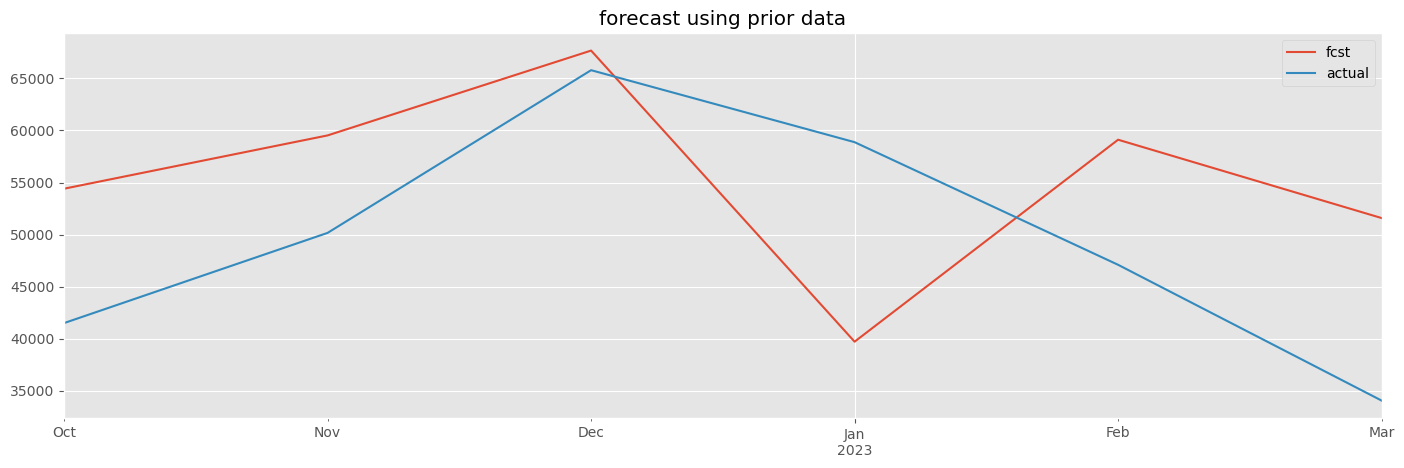

In [299]:
cv1.plot(title = 'forecast using prior data')

In [300]:
mean_absolute_percentage_error(cv1.actual , cv1.fcst)

0.2703556439909794

In [306]:
warnings.filterwarnings("ignore")
series = sales_monthly.sale
horizon = 1
start = 41
step_size = 1
order = (3,1,0)
seasonal_order = (0,1,1,9)

cv2 = cross_validate(series=series,horizon=horizon,start=start,step_size=step_size,
                    order = order,
                    seasonal_order = seasonal_order)

In [307]:
mean_absolute_percentage_error(cv2.actual , cv2.fcst)

0.34089030394368836

<AxesSubplot:title={'center':'forecast using prior data'}>

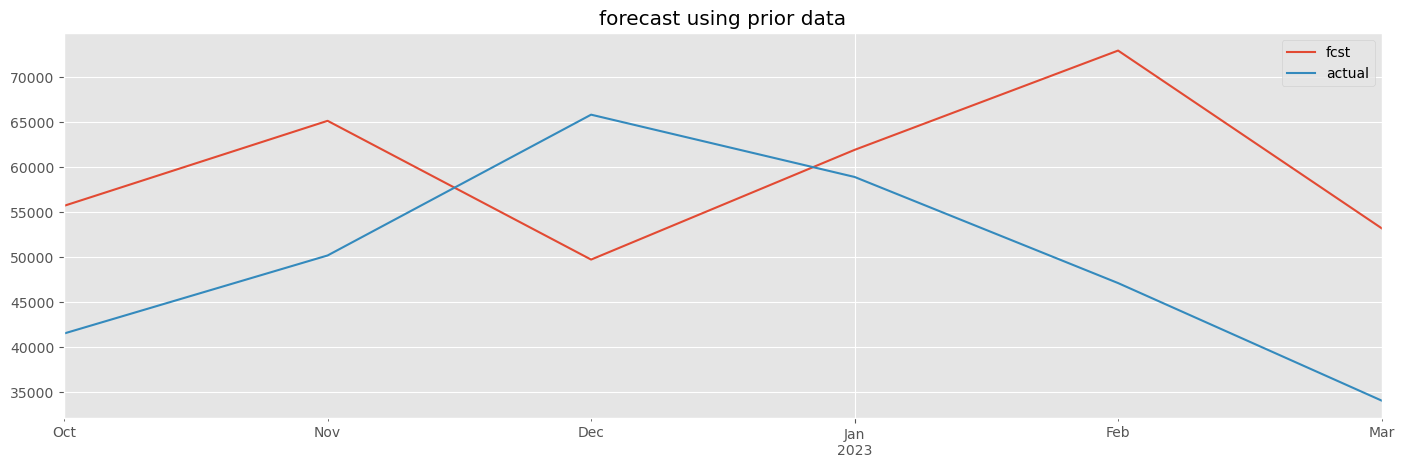

In [308]:
cv2.plot(title = 'forecast using prior data')

In [282]:
def grid_search_ARIMA(series,horizon,start,step_size,orders = [(1,0,0)],seasonal_orders = [(0,0,0,0)],trends=[None]):
    best_mape = np.inf
    best_order = None
    best_seasonal_order = None
    best_trend = None
    for order_ in orders:
        for seasonal_order_ in seasonal_orders:
            for trend_ in trends:
                
                cv = cross_validate(series,
                                    horizon,
                                    start,
                                    step_size,
                                    order = order_,
                                    seasonal_order = seasonal_order_,
                                    trend=trend_)
                if mean_absolute_percentage_error(cv.actual,cv.fcst)<best_mape:
                    best_mape = mean_absolute_percentage_error(cv.actual,cv.fcst)
                    best_order = order_
                    best_seasonal_order = seasonal_order_
                    best_trend = trend_
    return (best_order,best_seasonal_order, best_trend, best_mape)

In [304]:
series = sales_monthly.sale
horizon = 1
start = 41
step_size = 1
orders = [(4,1,7),(3,1,0)]
seasonal_orders = [(0,0,1,9),None]
trends = [None,'c']

grid_search_ARIMA(series = series,
                  horizon = horizon,
                  start = start,
                  step_size = step_size,
                  orders = orders,
                  seasonal_orders = seasonal_orders,
                  trends=trends)

((3, 1, 0), (0, 0, 1, 9), None, 0.2561527559902808)

In [305]:
Best_cv=cross_validate(sales_monthly.sale,1,42,1,order = (3,1,0),seasonal_order = (0,0,1,9),trend=None)
mean_absolute_percentage_error(Best_cv.actual,Best_cv.fcst)

0.22234122110704116

In [479]:
Best_cv=cross_validate(sales_monthly,1,42,1,order = (4,1,7),seasonal_order = None,trend='n')
mean_absolute_percentage_error(Best_cv.actual,Best_cv.fcst)

0.2622132340110648

# Predicting with Facebook Prophet

In [309]:
sales_monthly=pd.DataFrame(sales_monthly)
sales_monthly.reset_index(inplace=True)

In [313]:
sales_monthly.drop('forecast',axis=1,inplace=True)

In [314]:
sales_monthly.columns=['ds','y']

In [315]:
# fit model
m = Prophet()
m.fit(sales_monthly)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [321]:
future = m.make_future_dataframe(periods=6,freq='M')

In [317]:
forecast = m.predict(future)
print(forecast.columns)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,ds,yhat,yhat_lower,yhat_upper
49,2023-05-31,64027.586552,54639.004101,72762.779554
50,2023-06-30,34542.675711,25443.631263,43370.041001
51,2023-07-31,58994.931912,50096.026250,67787.775951
52,2023-08-31,60389.320907,51648.116536,68772.342436
53,2023-09-30,81393.624344,72631.056945,89410.172496


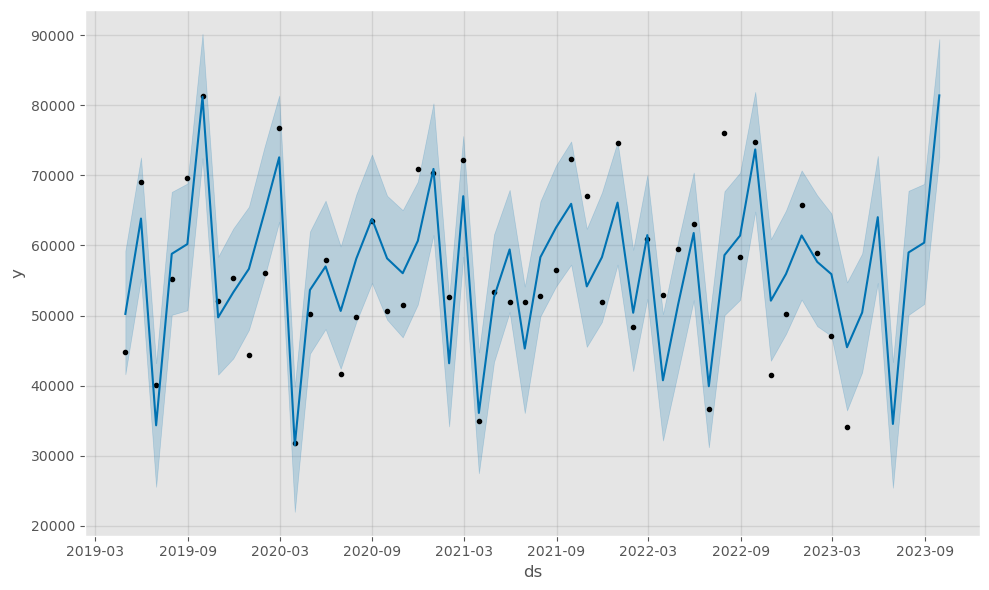

In [318]:
# plot forecast
m.plot(forecast);

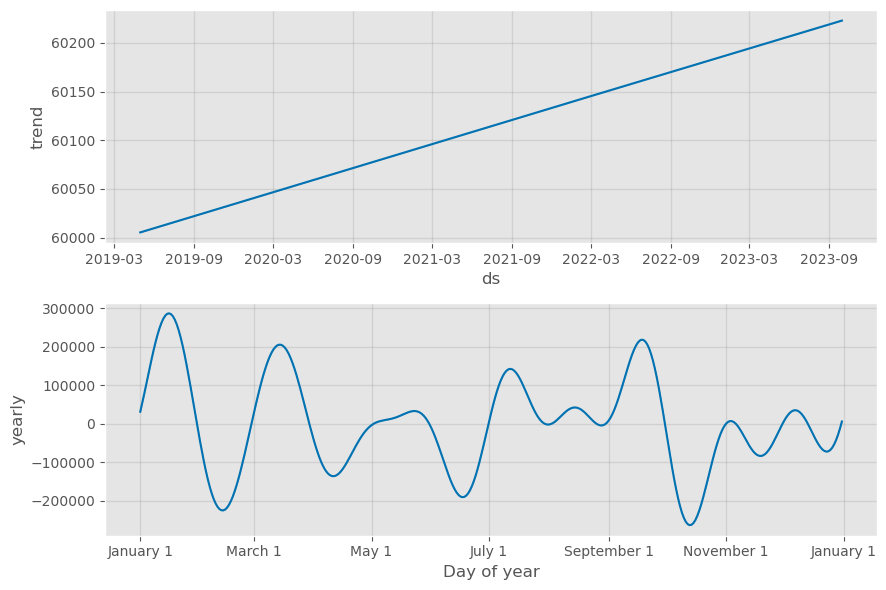

In [319]:
# plot individual components of forecast: trend, weekly/yearly seasonality,
m.plot_components(forecast);

In [322]:

#Starting from 35 months in, making a prediction every 180 days, 365 days into the future
df_cv = cross_validation(m, initial='1050 days', period='90 days', horizon ='180 days')
df_cv.head()

INFO:prophet:Making 3 forecasts with cutoffs between 2022-04-05 00:00:00 and 2022-10-02 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-04-30,45925.193520,39146.069269,52508.842882,59530.0,2022-04-05
1,2022-05-31,59613.783103,52249.422752,66612.367046,63025.0,2022-04-05
2,2022-06-30,40325.666191,34030.864025,47372.351544,36603.0,2022-04-05
3,2022-07-31,50615.614931,42770.399058,57559.058763,76032.0,2022-04-05
4,2022-08-31,62459.904966,55306.450028,69704.455018,58352.0,2022-04-05


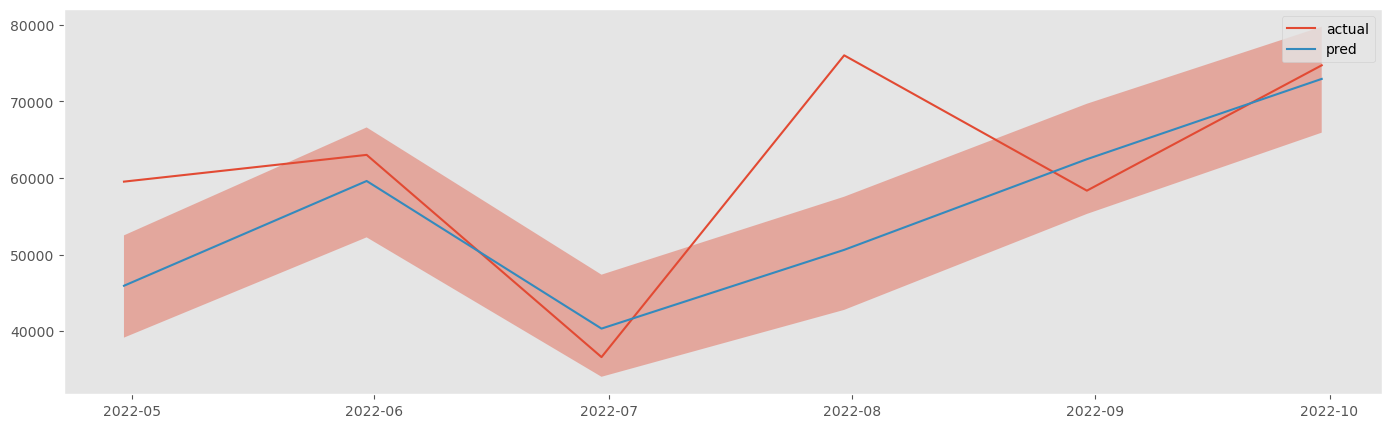

In [323]:
# Just looking at data from first cutoff
first_cut = df_cv[df_cv.cutoff == datetime(2022,4,5)]
plt.plot(first_cut.ds,first_cut.y,label='actual')
plt.plot(first_cut.ds,first_cut.yhat,label = 'pred')
plt.fill_between(first_cut.ds,first_cut.yhat_lower,first_cut.yhat_upper,alpha=0.4)
plt.grid()
plt.legend()

In [324]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,25 days,1.850908e+08,13604.806480,13604.806480,0.228537,0.228537,0.258021,0.0
1,27 days,5.710841e+08,23897.366395,23897.366395,0.314307,0.314307,0.372911,0.0
2,29 days,3.033802e+08,17417.812290,17417.812290,0.419737,0.419737,0.346928,0.0
3,56 days,1.163640e+07,3411.216897,3411.216897,0.054125,0.054125,0.055630,1.0
4,58 days,3.141442e+07,5604.857215,5604.857215,0.096053,0.096053,0.091651,1.0
5,59 days,1.022419e+08,10111.474758,10111.474758,0.201580,0.201580,0.183123,0.0
6,86 days,1.385824e+07,3722.666191,3722.666191,0.101704,0.101704,0.096782,1.0
7,88 days,7.134074e+04,267.096866,267.096866,0.003574,0.003574,0.003581,1.0
8,90 days,2.339581e+07,4836.921613,4836.921613,0.073518,0.073518,0.076324,1.0
9,117 days,6.459926e+08,25416.385069,25416.385069,0.334285,0.334285,0.401372,0.0


In [325]:
mean_absolute_percentage_error(df_cv.y,df_cv.yhat)

0.20507489945606555

In [480]:
mean_squared_error(df_cv.y,df_cv.yhat)

177917301.8815241

# Deep Learning

In [338]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

def get_train_test_data(df, input_hours, test_hours, sample_gap=3):
    """
    Utility processing function that splits an hourly time series into 
    train and test with keras-friendly format, according to user-specified
    choice of shape.    
    
    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    input_hours (int): length of sequence input to network 
    test_hours (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5
    
    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y     
    """
    
    forecast_series = df.values # reducing our forecast series to last n days

    train = forecast_series[:-test_hours] # training data is remaining days until amount of test_hours
    test = forecast_series[-test_hours:] # test data is the remaining test_hours

    train_X, train_y = [], []

    # range 0 through # of train samples - input_hours by sample_gap. 
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_hours, sample_gap): 
        train_X.append(train[i:i+input_hours]) # each training sample is of length input hours
        train_y.append(train[i+input_hours]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_hours] 
    test_y = test[input_hours:] # test_y is remaining values from test set
    
    return train_X, test_X_init, train_y, test_y

In [378]:
sales_daily_new

2019-04-06     696.0
2019-04-07    1624.0
2019-04-08    2144.0
2019-04-09    1895.0
2019-04-10    1815.0
               ...  
2023-03-15    3028.0
2023-03-16    -100.0
2023-03-17       0.0
2023-03-18       0.0
2023-03-19      -6.0
Freq: D, Name: sale, Length: 1444, dtype: float64

In [405]:
input_hours = 30
test_hours = 60

train_X, test_X_init, train_y, test_y = get_train_test_data(df=sales_daily_new,
                            input_hours=input_hours, test_hours=test_hours,sample_gap=3)

In [406]:
print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))
print('Test input shape: {}'.format(test_X_init.shape))
print('Test output shape: {}'.format(test_y.shape))

Training input shape: (452, 30, 1)
Training output shape: (452,)
Test input shape: (30,)
Test output shape: (30,)


In [407]:
#RNN
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells  
    epochs (int): number of training epochs   
    """

    # initialize model
    model = Sequential() 
    
    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

In [417]:
model = fit_SimpleRNN(train_X, train_y, cell_units=30, epochs=5000)

In [412]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 11 values with 2nd through 12th
        X_init[:,-1,:] = pred # replace 12th value with prediction
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps 
    
    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title   
    """
    
    y_preds = predict(test_X_init, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X_init.shape[0], test_hours)  #predict range is going to be from end of X_init to length of test_hours
    
    #using our ranges we plot X_init
    plt.plot(start_range, test_X_init)
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    
    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

1/1 [==============================] - 0s 18ms/step


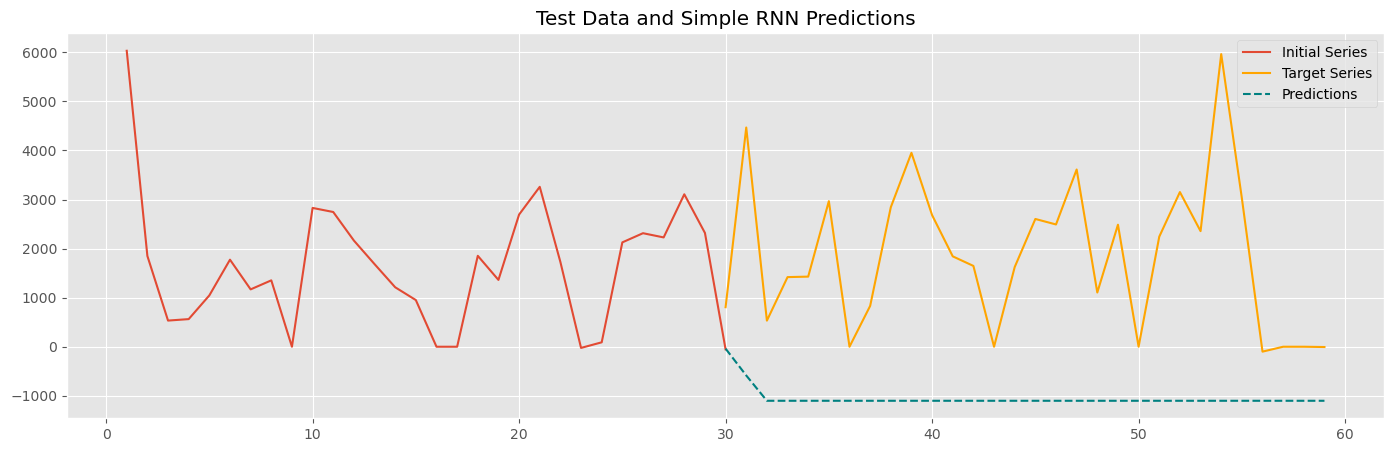

In [418]:
predict_and_plot(test_X_init, test_y, model,
                 'Test Data and Simple RNN Predictions')

In [419]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_11 (SimpleRNN)   (None, 30)                960       
                                                                 
 dense_12 (Dense)            (None, 1)                 31        
                                                                 
Total params: 991
Trainable params: 991
Non-trainable params: 0
_________________________________________________________________


In [428]:
#LSTM
def fit_LSTM(train_X, train_y, cell_units, epochs):
    """
    Fit LSTM to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1))) #,return_sequences= True))
    #model.add(LSTM(cell_units_l2, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

1/1 [==============================] - 0s 16ms/step


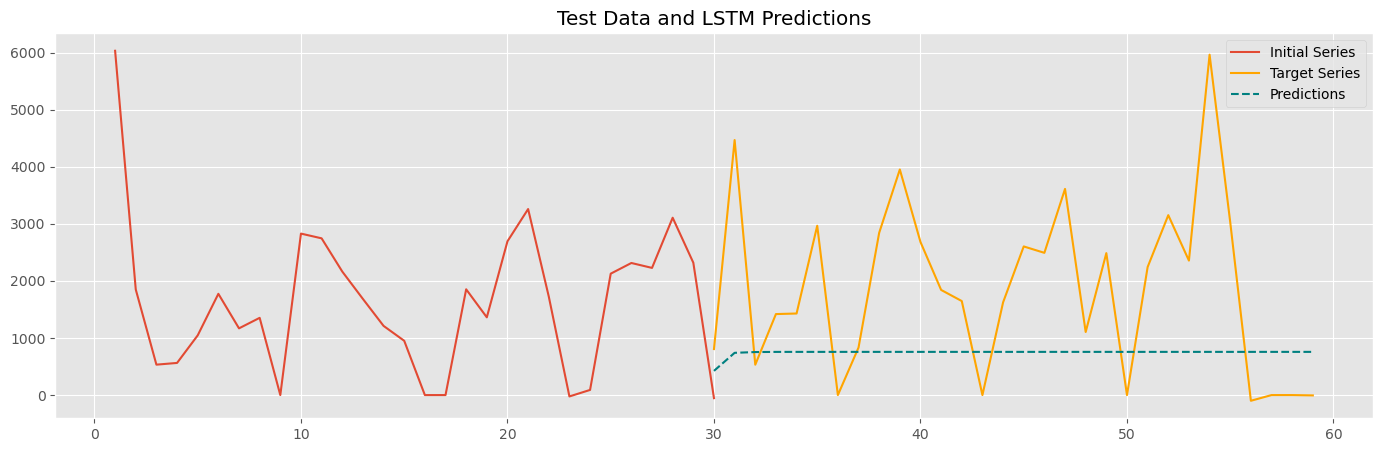

In [429]:
model = fit_LSTM(train_X, train_y, cell_units=100, epochs=1000) 

predict_and_plot(test_X_init, test_y, model, 
                 'Test Data and LSTM Predictions')

In [422]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 70)                20160     
                                                                 
 dense_14 (Dense)            (None, 1)                 71        
                                                                 
Total params: 20,231
Trainable params: 20,231
Non-trainable params: 0
_________________________________________________________________
